# Fusion Strategies for Multisource Geospatial Data: Comparing MKL, Tabular, and Deep Learning Models​

- Tabular ML
- CNN
- MKL

# 1. Tabular ML

## 1.1 Resampling the nicfi to match the resolution of sentinel-2

### 1.1.1 DownScaling and helper function with the average method

In [10]:
# 

import os
import random
from pathlib import Path
import matplotlib.pyplot as plt
import rasterio
from rasterio.enums import Resampling

def downscaling(input_tif, output_tif, matching_tif, bounds_tolerance=1e-4):
    """
    Downscale an input GeoTIFF to match the resolution and dimensions of another GeoTIFF, 
    preserving geospatial alignment, and save the result to an output GeoTIFF.
    
    Args:
        input_tif (str): Path to the input GeoTIFF file to be downscaled.
        output_tif (str): Path where the downscaled GeoTIFF will be saved.
        matching_tif (str): Path to the reference GeoTIFF file whose resolution and size will be matched.
        bounds_tolerance (float): Maximum allowed difference in bounds coordinates (in degrees).
    """
    # Open the reference (matching) GeoTIFF
    with rasterio.open(matching_tif) as match_src:
        # Extract target height, width, transform, and CRS from the reference
        target_height = match_src.height
        target_width = match_src.width
        target_transform = match_src.transform
        target_crs = match_src.crs

    # Open the input GeoTIFF
    with rasterio.open(input_tif) as input_src:
        # Print input shape
        print(f"Input TIF shape: bands={input_src.count}, height={input_src.height}, width={input_src.width}")
        print(f"Target shape: bands={input_src.count}, height={target_height}, width={target_width}")
        
        # Ensure the CRS match
        if input_src.crs != target_crs:
            raise ValueError("CRS mismatch between input_tif and matching_tif.")
        
        # Get both bounds
        input_bounds = input_src.bounds
        target_bounds = rasterio.transform.array_bounds(
            target_height, target_width, target_transform
        )
        
        # Check bounds with tolerance
        bounds_diff = [
            abs(input_bounds.left - target_bounds[0]),
            abs(input_bounds.bottom - target_bounds[1]),
            abs(input_bounds.right - target_bounds[2]),
            abs(input_bounds.top - target_bounds[3])
        ]
        
        if max(bounds_diff) > bounds_tolerance:
            print("Input bounds:", input_bounds)
            print("Target bounds:", target_bounds)
            print("Maximum bounds difference:", max(bounds_diff))
            print("Differences:", bounds_diff)
            raise ValueError(f"Bounds mismatch exceeds tolerance of {bounds_tolerance} degrees.")
        
        # Perform the resampling to match dimensions
        data = input_src.read(
            out_shape=(input_src.count, target_height, target_width),
            resampling=Resampling.average
        )
        
        # Print output shape
        print(f"Output data shape: bands={data.shape[0]}, height={data.shape[1]}, width={data.shape[2]}")
        # print the matching tif 's shape
        print(f"Matching TIF shape: bands={match_src.count}, height={match_src.height}, width={match_src.width}")
        
        
        # Update the output profile to match the reference
        output_profile = input_src.profile.copy()
        output_profile.update({
            'height': target_height,
            'width': target_width,
            'transform': target_transform,
            'crs': target_crs
        })
        
        # Write the resampled data to the output GeoTIFF
        with rasterio.open(output_tif, 'w', **output_profile) as dst:
            dst.write(data)


def procese_all_tifs(input_folder, output_folder, matching_folder):
    # the input folder are the nicfi tif folder
    # the output folder are the downscaled nicfi tif folder
    # the matching folder are the sentinel tif folder which used to be schema for the nicfi
    
    # get the list of tif files in the input folder
    input_tifs = [f for f in os.listdir(input_folder) if f.endswith('.tif')]
    macthed_tifs = [f for f in os.listdir(matching_folder) if f.endswith('.tif')]



    # process each input tif file
    for input_tif in input_tifs:
        input_path = os.path.join(input_folder, input_tif)
        output_path = os.path.join(output_folder, input_tif.replace('.tif', '_rs.tif'))# change the name of file with _rs

        # get the file name of the matching tif file(sentinel [index]-YYYYMMDD-sentinel.tif),but nicfi index-YYYY-MM-nicfi.tif
        match_tif= input_tif.split('-')[0]+"-"+input_tif.split('-')[1]+input_tif.split('-')[2]+'01-sentinel.tif'

        matching_path = os.path.join(matching_folder, match_tif)
        downscaling(input_path, output_path, matching_path)
        print(f"Processing: {input_tif}, Saved target raster to: {output_path},mached target raster to: {matching_path}")
    


def visualize_random_samples(original_nicfi_folder, original_sentinel_folder, downscaled_nicfi_folder, num_samples=20):
    """
    Visualize random samples comparing original NICFI, downscaled NICFI, and Sentinel images in a grid.

    Args:
        original_nicfi_folder (str): Path to the folder containing original NICFI TIFFs.
        original_sentinel_folder (str): Path to the folder containing Sentinel TIFFs.
        downscaled_nicfi_folder (str): Path to the folder containing downscaled NICFI TIFFs.
        num_samples (int): Number of random sample sets to display (default: 20).
    """
    # Get the list of NICFI and Sentinel files
    nicfi_files = sorted([f for f in os.listdir(original_nicfi_folder) if f.endswith('-nicfi.tif')])
    sentinel_files = sorted([f for f in os.listdir(original_sentinel_folder) if f.endswith('-sentinel.tif')])

    # Select random samples
    selected_indices = random.sample(range(len(nicfi_files)), min(num_samples, len(nicfi_files)))

    # Create a grid of 20 sets with 3 images each
    fig, axes = plt.subplots(num_samples, 3, figsize=(18, 5 * num_samples))
    fig.suptitle('Comparison of Original NICFI, Downscaled NICFI, and Sentinel Images', fontsize=16)

    # Iterate over selected samples
    for idx, file_idx in enumerate(selected_indices):
        # Extract corresponding files
        original_nicfi_file = nicfi_files[file_idx]
        file_index = original_nicfi_file.split('-')[0]
        
        sentinel_file = next((f for f in sentinel_files if f.split('-')[0] == file_index), None)
        downscaled_nicfi_file = f"{original_nicfi_file.replace('.tif', '_rs.tif')}"

        # Ensure all files exist
        if not sentinel_file or not os.path.exists(os.path.join(downscaled_nicfi_folder, downscaled_nicfi_file)):
            print(f"Skipping sample {file_index}: Missing corresponding files.")
            continue

        original_nicfi_path = os.path.join(original_nicfi_folder, original_nicfi_file)
        sentinel_path = os.path.join(original_sentinel_folder, sentinel_file)
        downscaled_nicfi_path = os.path.join(downscaled_nicfi_folder, downscaled_nicfi_file)

        # Load and visualize the original NICFI image
        with rasterio.open(original_nicfi_path) as src:
            data = src.read(1)
            info = f"Bands={src.count}, Height={src.height}, Width={src.width}"
            axes[idx, 0].imshow(data, cmap='viridis')
            axes[idx, 0].set_title(f"Original NICFI\n{Path(original_nicfi_file).name}", fontsize=10)
            axes[idx, 0].text(0.5, -0.1, info, ha='center', va='top', transform=axes[idx, 0].transAxes, fontsize=8)
            axes[idx, 0].axis('off')

        # Load and visualize the downscaled NICFI image
        with rasterio.open(downscaled_nicfi_path) as src:
            data = src.read(1)
            info = f"Bands={src.count}, Height={src.height}, Width={src.width}"
            axes[idx, 1].imshow(data, cmap='viridis')
            axes[idx, 1].set_title(f"Downscaled NICFI\n{Path(downscaled_nicfi_file).name}", fontsize=10)
            axes[idx, 1].text(0.5, -0.1, info, ha='center', va='top', transform=axes[idx, 1].transAxes, fontsize=8)
            axes[idx, 1].axis('off')

        # Load and visualize the Sentinel image
        with rasterio.open(sentinel_path) as src:
            data = src.read(2) # first band is too small range has bad resulotion 
            info = f"Bands={src.count}, Height={src.height}, Width={src.width}"
            axes[idx, 2].imshow(data, cmap='viridis')
            axes[idx, 2].set_title(f"Sentinel\n{Path(sentinel_file).name}", fontsize=10)
            axes[idx, 2].text(0.5, -0.1, info, ha='center', va='top', transform=axes[idx, 2].transAxes, fontsize=8)
            axes[idx, 2].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
    plt.show()


In [6]:

nicif_folder_path= r'G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_nicfi'
output_folder_path= r'G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_downscaled_nicfi'
target_folder_path= r'G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_sentinel'
procese_all_tifs(nicif_folder_path,output_folder_path,target_folder_path)

Input TIF shape: bands=4, height=42, width=42
Target shape: bands=4, height=22, width=21
Output data shape: bands=4, height=22, width=21
Matching TIF shape: bands=26, height=22, width=21
Processing: 0-2024-03-nicfi.tif, Saved target raster to: G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_downscaled_nicfi\0-2024-03-nicfi_rs.tif,mached target raster to: G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_sentinel\0-20240301-sentinel.tif
Input TIF shape: bands=4, height=42, width=42
Target shape: bands=4, height=22, width=21
Output data shape: bands=4, height=22, width=21
Matching TIF shape: bands=26, height=22, width=21
Processing: 0-2024-04-nicfi.tif, Saved target raster to: G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_downscaled_nicfi\0-2024-04-nicfi_rs.tif,mached target raster to: G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_sentinel\0-20240401-sentinel.tif
Input TIF shape: bands=4, height=42, width=42
Target shape: bands=4, height=22, width=21
Output data shape: bands=4,

### 1.1.2 Visualize the results of the resampling

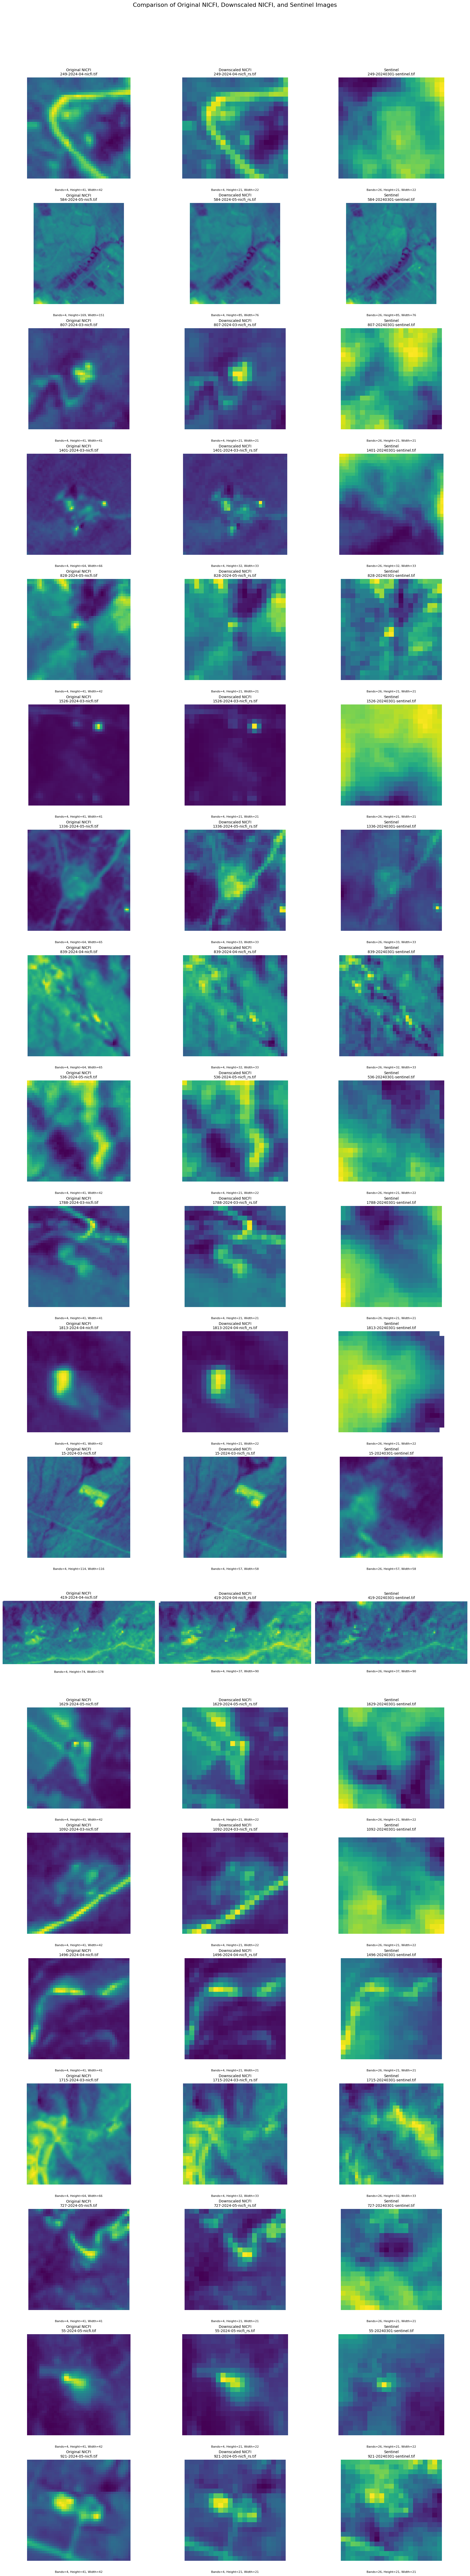

In [11]:
visualize_random_samples(nicif_folder_path, target_folder_path, output_folder_path, num_samples=20)

In [12]:
# count the images in the resampleing tif's folder

resample_nicfi_folder= r'G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_downscaled_nicfi'
resample_nicfi_files = sorted([f for f in os.listdir(resample_nicfi_folder) if f.endswith('_rs.tif')])
print(f"Total number of resampleing tif's: {len(resample_nicfi_files)}")

Total number of resampleing tif's: 3636


## 1.2 Tabularize the bands of the Downscaled Nicfi and sentinel image 

Sentinel bands : 

https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED

| Name       | Units  | Min | Max | Scale   | Pixel Size | Wavelength                              | Description                                                                                  |
|------------|--------|-----|-----|---------|------------|------------------------------------------|----------------------------------------------------------------------------------------------|
| B1         |        |     |     | 0.0001  | 60 meters  | 443.9nm (S2A) / 442.3nm (S2B)           | Aerosols                                                                                     |
| B2         |        |     |     | 0.0001  | 10 meters  | 496.6nm (S2A) / 492.1nm (S2B)           | Blue                                                                                         |
| B3         |        |     |     | 0.0001  | 10 meters  | 560nm (S2A) / 559nm (S2B)               | Green                                                                                        |
| B4         |        |     |     | 0.0001  | 10 meters  | 664.5nm (S2A) / 665nm (S2B)             | Red                                                                                          |
| B5         |        |     |     | 0.0001  | 20 meters  | 703.9nm (S2A) / 703.8nm (S2B)           | Red Edge 1                                                                                   |
| B6         |        |     |     | 0.0001  | 20 meters  | 740.2nm (S2A) / 739.1nm (S2B)           | Red Edge 2                                                                                   |
| B7         |        |     |     | 0.0001  | 20 meters  | 782.5nm (S2A) / 779.7nm (S2B)           | Red Edge 3                                                                                   |
| B8         |        |     |     | 0.0001  | 10 meters  | 835.1nm (S2A) / 833nm (S2B)             | NIR                                                                                          |
| B8A        |        |     |     | 0.0001  | 20 meters  | 864.8nm (S2A) / 864nm (S2B)             | Red Edge 4                                                                                   |
| B9         |        |     |     | 0.0001  | 60 meters  | 945nm (S2A) / 943.2nm (S2B)             | Water vapor                                                                                  |
| B11        |        |     |     | 0.0001  | 20 meters  | 1613.7nm (S2A) / 1610.4nm (S2B)         | SWIR 1                                                                                       |
| B12        |        |     |     | 0.0001  | 20 meters  | 2202.4nm (S2A) / 2185.7nm (S2B)         | SWIR 2                                                                                       |
| AOT        |        |     |     | 0.001   | 10 meters  |                                          | Aerosol Optical Thickness                                                                   |
| WVP        | cm     |     |     | 0.001   | 10 meters  |                                          | Water Vapor Pressure. Height water would occupy if vapor condensed into liquid.              |
| SCL        |        | 1   | 11  |         | 20 meters  |                                          | Scene Classification Map ("No Data" value of 0 is masked out)                                |
| TCI_R      |        |     |     |         | 10 meters  |                                          | True Color Image, Red channel                                                               |
| TCI_G      |        |     |     |         | 10 meters  |                                          | True Color Image, Green channel                                                             |
| TCI_B      |        |     |     |         | 10 meters  |                                          | True Color Image, Blue channel                                                              |
| MSK_CLDPRB |        | 0   | 100 |         | 20 meters  |                                          | Cloud Probability Map (missing in some products)                                             |
| MSK_SNWPRB |        | 0   | 100 |         | 10 meters  |                                          | Snow Probability Map (missing in some products)                                              |
| QA10       |        |     |     |         | 10 meters  |                                          | Always empty                                                                                 |
| QA20       |        |     |     |         | 20 meters  |                                          | Always empty                                                                                 |
| QA60       |        |     |     |         | 60 meters  |                                          | Cloud mask. Masked out between 2022-01-25 to 2024-02-28 inclusive.         


Nicfi bands : 

https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_NAIP

| **Resolution** | **4.77 meters** |
|-----------------|-----------------|

| **Name** | **Min** | **Max** | **Scale** | **Description**     |
|-----------|---------|---------|-----------|---------------------|
| B         | 0       | 10000   | 0.0001    | Blue                |
| G         | 0       | 10000   | 0.0001    | Green               |
| R         | 0       | 10000   | 0.0001    | Red                 |
| N         | 0       | 10000   | 0.0001    | Near-infrared       |


Parquet method table: 
| Column Name      | Description                                                                 |
|------------------|-----------------------------------------------------------------------------|
| `dp_index`       | Data point index, based on the name of the TIFF file `xxxx-YYYY-MM-nicfi.tif`, where `xxxx` is the index. |
| `pixel_index`    | Pixel index, based on the order of the pixel in the TIFF file, using a 40x40 NICFI TIFF (range: 1 to 1600). |
| `date`           | Date column for the TIFF, extracted from the filename `xxxx-YYYY-MM-nicfi.tif`, using `YYYY-MM` format. |
| `latitude`       | Latitude of the pixel.                                                    |
| `longitude`      | Longitude of the pixel.                                                   |
| `nicfi_band1`    | NICFI band 1.                                                             |
| `nicfi_band2`    | NICFI band 2.                                                             |
| `nicfi_band3`    | NICFI band 3.                                                             |
| `nicfi_band4`    | NICFI band 4.                                                             |
| `s1_band1`-`s1_band26` | Sentinel Image 1 bands 1 through 26.                                     |
| `s2_band1`-`s2_band26` | Sentinel Image 2 bands 1 through 26.                                     |
| `s3_band1`-`s3_band26` | Sentinel Image 3 bands 1 through 26.                                     |
| `target`         | Target band.                                                              |

In [36]:
import os
import numpy as np
import pandas as pd
import rasterio
from pathlib import Path

default_experiment_tif_index=[1216, 161, 323, 388, 488, 1134, 1359, 750, 1585, 529, 661, 662, 1271, 1529, 346,1473, 869, 1553, 88, 1503, 1164, 469, 1129, 1526, 773, 1625, 745, 50, 1320, 1290, 188, 494, 960, 1792, 743, 1336, 1062, 951, 1618, 1171, 383, 668, 613, 877, 1283, 1158, 719, 925, 220, 485, 892, 536, 163, 1194, 1457, 1664, 1815, 421, 979, 1099, 1088, 1082, 525, 1315, 667, 53, 303, 1217, 406, 297, 1807, 1324, 1752, 1528, 709, 1319, 1096, 1317, 203, 1523, 442, 1425, 1549, 435, 804, 1719, 739, 512, 575, 1704, 646, 1741, 224, 1369, 731, 1656, 844, 1450, 154, 1191, 1822, 1383, 465, 1187, 626, 493, 607, 1645, 1667, 212, 476, 1530, 609, 184, 7]

def calculate_missing_percentage(data_array):
    """
    Calculate the percentage of missing (NaN) values in a given array.
    
    Args:
        data_array (np.ndarray): The data array to check for missing values.

    Returns:
        float: The percentage of missing (NaN) values.
    """
    return np.sum(np.isnan(data_array)) / data_array.size * 100

def tabularize_bands_to_parquet(downscaled_nicfi_folder_path, original_sentinel_folder_path, target_folder_path, parquet_save_path,caculate_missing=False,experiment_index_list=default_experiment_tif_index):
    """
    Tabularize the bands of the NICFI and Upscaled Sentinel images without using JAX,
    and save the data in Parquet format.
    
    Args:
        downscaled_nicfi_folder_path (str): Path to the NICFI folder, nicfi format: xxxx-YYYY-MM-nicfi_rs.tif
        original_sentinel_folder_path (str): Path to the Sentinel folder, sentinel format: xxxx-YYYYMMDD-sentinel.tif
        target_folder_path (str): Path to the target folder, target format: xxxx-YYYY-MM-target.tif
        parquet_save_path (str): Path to save the Parquet file.
    """
    # Column design
    parquet_columns = [
        'dp_index', 'pixel_index', 'date', 'latitude', 'longitude',
        *[f'nicfi_band{i+1}' for i in range(4)],
        *[f's{i+1}_band{j+1}' for i in range(3) for j in range(26)],
        'target'
    ]
    
    if not os.path.exists(parquet_save_path):
        # Create an empty Parquet file to start appending
        pd.DataFrame(columns=parquet_columns).to_parquet(parquet_save_path, engine='pyarrow', index=False)

    for nicfi_file in os.listdir(downscaled_nicfi_folder_path):
        nicfi_path = os.path.join(downscaled_nicfi_folder_path, nicfi_file)
        nicfi_file_name = Path(nicfi_file).name
        row_date = nicfi_file_name.split('-')[1] + nicfi_file_name.split('-')[2]
        row_dp_index = nicfi_file_name.split('-')[0]
        if int(row_dp_index) not in experiment_index_list:
            continue

        target_file = f"{row_dp_index}-{row_date[0:4]}-{row_date[4:6]}-target.tif"
        target_path = os.path.join(target_folder_path, target_file)

        if not os.path.exists(target_path):
            print(f"Target file not found: {target_file}")
            continue

        original_sentinel_files = [f for f in os.listdir(original_sentinel_folder_path)
                                   if row_dp_index == f.split('-')[0] and row_date in f]
        original_sentinel_files.sort()

        if len(original_sentinel_files) != 3:
            print(f"Expected 3 upscaled sentinel files for {row_date}, but found {len(original_sentinel_files)}")
            continue

        with rasterio.open(nicfi_path) as src:
            nicfi_data = src.read()  # Shape: (4, height, width)
            height, width = nicfi_data.shape[1:]
            rows, cols = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
            coords = np.stack([rows.flatten(), cols.flatten()], axis=-1)

            lats, lons = [], []
            for coord in coords:
                lon, lat = src.transform * (coord[1], coord[0])
                lats.append(lat)
                lons.append(lon)

        with rasterio.open(target_path) as src:
            target_data = np.array(src.read(1))  # Single-band target data

        sentinel_data = []
        for sentinel_file in original_sentinel_files:
            with rasterio.open(os.path.join(original_sentinel_folder_path, sentinel_file)) as src:
                sentinel_data.append(np.array(src.read()))  # Shape: (26, height, width)

        rows_list = []
        pixel_indices = range(height * width)

        def process_pixel(idx):
            i, j = divmod(idx, width)

            # boundary check
            if i >= height or j >= width:
                print(f"Invalid pixel index: {idx}, out of bounds")
                return
            
            # Handling missing values (NaN) in bands and target
            nicfi_values = {
                f'nicfi_band{b+1}': (nicfi_data[b, i, j] if not np.isnan(nicfi_data[b, i, j]) else None) 
                for b in range(4)
            }

            sentinel_values = {
                f's{s_idx+1}_band{b+1}': (sentinel_data[s_idx][b, i, j] if not np.isnan(sentinel_data[s_idx][b, i, j]) else None)
                for s_idx in range(3) for b in range(26)
            }

            target_value = (target_data[i, j] if not np.isnan(target_data[i, j]) else None)

            row_data = {
                'dp_index': row_dp_index,
                'pixel_index': idx + 1,
                'date': f"{row_date[0:4]}-{row_date[4:6]}",
                'latitude': lats[i * width + j],
                'longitude': lons[i * width + j],
                **nicfi_values,
                **sentinel_values,
                'target': target_value
            }
            return row_data

        # Process all pixels using a loop instead of jax.vmap
        for idx in pixel_indices:
            rows_list.append(process_pixel(idx))

        df = pd.DataFrame(rows_list, columns=parquet_columns)

        # Calculate missing data percentage for each band and target
        if caculate_missing:
            nicfi_missing = calculate_missing_percentage(nicfi_data)
            sentinel_missing = sum(calculate_missing_percentage(sentinel_band) for sentinel_band in sentinel_data) / 3
            target_missing = calculate_missing_percentage(target_data)

            
            print(f"NICFI bands missing data: {nicfi_missing}%")
            print(f"Sentinel bands missing data: {sentinel_missing}%")
            print(f"Target data missing: {target_missing}%")

        print(f"Processed {nicfi_file} with {len(rows_list)} pixels, with sentinel file{original_sentinel_files}")
        # Append to Parquet file
        save_to_parquet(df, parquet_save_path)



def save_to_parquet(df, parquet_save_path):
    rows_added = 0  # Variable to store the number of rows added
    total_rows = 0  # Variable to store the total number of rows after update

    if os.path.exists(parquet_save_path):
        # Read the existing Parquet file
        existing_df = pd.read_parquet(parquet_save_path, engine='pyarrow')
        # Append the new data
        combined_df = pd.concat([existing_df, df], ignore_index=True)
        # Calculate how many rows were added
        rows_added = len(combined_df) - len(existing_df)
    else:
        combined_df = df
        # All rows in the DataFrame are new
        rows_added = len(df)

    # Update total row count
    total_rows = len(combined_df)

    # Save the combined DataFrame to Parquet
    combined_df.to_parquet(parquet_save_path, engine='pyarrow', index=False)

    # Print the number of rows added and the total rows
    print(f"{rows_added} rows added to {parquet_save_path}. Total rows now: {total_rows}")

### 1.2.1 Pick the experimental tif index 
- all the target with the value which have non-zero value in the target band
- add more 100 tif which are all zero value 

In [16]:
target_folder_path= r'G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_target_s'

non_zero_files=[]
for target_file in os.listdir(target_folder_path):
    target_path = os.path.join(target_folder_path, target_file)
    with rasterio.open(target_path) as src:
        target_data = np.array(src.read(1))  # Single-band target data
        
        # check all the values in the target data whether they are all zero or not
        if not np.all(target_data == 0):
            non_zero_files.append(target_file)

print(f"Total number of non-zero files: {len(non_zero_files)}")

Total number of non-zero files: 18


In [19]:
print(non_zero_files)

#print the index of the non-zero files
none_zero_index=[int(f.split('-')[0]) for f in non_zero_files]
print(none_zero_index)

# turn the list into a set
none_zero_index_set=set(none_zero_index)
print(none_zero_index_set)

['1134-2024-04-target.tif', '1216-2024-03-target.tif', '1216-2024-05-target.tif', '1271-2024-05-target.tif', '1359-2024-05-target.tif', '1529-2024-03-target.tif', '1585-2024-03-target.tif', '1585-2024-04-target.tif', '161-2024-04-target.tif', '323-2024-04-target.tif', '346-2024-04-target.tif', '388-2024-04-target.tif', '488-2024-05-target.tif', '529-2024-04-target.tif', '661-2024-03-target.tif', '662-2024-04-target.tif', '750-2024-03-target.tif', '750-2024-04-target.tif']
[1134, 1216, 1216, 1271, 1359, 1529, 1585, 1585, 161, 323, 346, 388, 488, 529, 661, 662, 750, 750]
{1216, 161, 323, 388, 488, 1134, 1359, 750, 1585, 529, 661, 662, 1271, 1529, 346}


In [22]:
# get all the indexs in a set:
all_index=[int(f.split('-')[0]) for f in os.listdir(target_folder_path)]
all_index_set=set(all_index)

print(f"Total number of files: {len(all_index_set)}")

# get the 100 random indexs in the all_index_set but not in none_zero_index_set
random_index_set=all_index_set-none_zero_index_set
print(f"Total number of random indexs: {len(random_index_set)}")
print(random_index_set)

# pick 100 random indexs from the random_index_set(convert to the list)
random_index_list=list(random_index_set)
random_index=random.sample(random_index_list, 100)
print(random_index)

Total number of files: 1212
Total number of random indexs: 1197
{0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 42, 43, 44, 45, 49, 50, 51, 52, 53, 55, 58, 66, 68, 72, 76, 77, 78, 80, 81, 83, 84, 88, 90, 92, 93, 98, 99, 101, 102, 103, 105, 106, 107, 108, 109, 111, 115, 116, 119, 124, 125, 126, 127, 129, 130, 131, 132, 133, 134, 135, 136, 138, 139, 141, 144, 147, 150, 151, 152, 153, 154, 156, 163, 167, 168, 169, 175, 177, 184, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197, 202, 203, 204, 205, 207, 208, 209, 210, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 227, 229, 233, 236, 237, 238, 241, 244, 245, 246, 247, 248, 249, 250, 256, 257, 261, 265, 266, 270, 272, 273, 274, 276, 277, 279, 280, 281, 282, 283, 285, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 303, 304, 305, 307, 312, 313, 314, 315, 320, 321, 324, 325, 326, 327, 329, 330, 332, 3

- Example of the dp index:
[1216, 161, 323, 388, 488, 1134, 1359, 750, 1585, 529, 661, 662, 1271, 1529, 346,1473, 869, 1553, 88, 1503, 1164, 469, 1129, 1526, 773, 1625, 745, 50, 1320, 1290, 188, 494, 960, 1792, 743, 1336, 1062, 951, 1618, 1171, 383, 668, 613, 877, 1283, 1158, 719, 925, 220, 485, 892, 536, 163, 1194, 1457, 1664, 1815, 421, 979, 1099, 1088, 1082, 525, 1315, 667, 53, 303, 1217, 406, 297, 1807, 1324, 1752, 1528, 709, 1319, 1096, 1317, 203, 1523, 442, 1425, 1549, 435, 804, 1719, 739, 512, 575, 1704, 646, 1741, 224, 1369, 731, 1656, 844, 1450, 154, 1191, 1822, 1383, 465, 1187, 626, 493, 607, 1645, 1667, 212, 476, 1530, 609, 184, 7]

In [23]:
Model_index_list=[1216, 161, 323, 388, 488, 1134, 1359, 750, 1585, 529, 661, 662, 1271, 1529, 346,1473, 869, 1553, 88, 1503, 1164, 469, 1129, 1526, 773, 1625, 745, 50, 1320, 1290, 188, 494, 960, 1792, 743, 1336, 1062, 951, 1618, 1171, 383, 668, 613, 877, 1283, 1158, 719, 925, 220, 485, 892, 536, 163, 1194, 1457, 1664, 1815, 421, 979, 1099, 1088, 1082, 525, 1315, 667, 53, 303, 1217, 406, 297, 1807, 1324, 1752, 1528, 709, 1319, 1096, 1317, 203, 1523, 442, 1425, 1549, 435, 804, 1719, 739, 512, 575, 1704, 646, 1741, 224, 1369, 731, 1656, 844, 1450, 154, 1191, 1822, 1383, 465, 1187, 626, 493, 607, 1645, 1667, 212, 476, 1530, 609, 184, 7]

# turn to a set and print the length
Model_index_set=set(Model_index_list)
print(len(Model_index_set))

115


### 1.2.2 Perform the tabularization for the experimental tif 115 index

In [37]:
import os
import time


downscaled_nicfi_folder_path= r'G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_downscaled_nicfi'
original_sentinel_folder_path= r'G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_sentinel'
target_folder_path= r'G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_target_s'
parquet_save_path= r'G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_parquet\dev_downscaled.parquet'

start_time = time.time()

tabularize_bands_to_parquet(downscaled_nicfi_folder_path, original_sentinel_folder_path, target_folder_path, parquet_save_path,caculate_missing=True,experiment_index_list=Model_index_list)

end_time = time.time()

print(f"Execution time: {end_time - start_time} seconds")

NICFI bands missing data: 0.0%
Sentinel bands missing data: 7.6923076923076925%
Target data missing: 0.0%
Processed 1062-2024-03-nicfi_rs.tif with 462 pixels, with sentinel file['1062-20240301-sentinel.tif', '1062-20240311-sentinel.tif', '1062-20240321-sentinel.tif']
462 rows added to G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_parquet\dev_downscaled.parquet. Total rows now: 462
NICFI bands missing data: 0.0%
Sentinel bands missing data: 7.6923076923076925%
Target data missing: 0.0%
Processed 1062-2024-04-nicfi_rs.tif with 462 pixels, with sentinel file['1062-20240401-sentinel.tif', '1062-20240411-sentinel.tif', '1062-20240421-sentinel.tif']
462 rows added to G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_parquet\dev_downscaled.parquet. Total rows now: 924
NICFI bands missing data: 0.0%
Sentinel bands missing data: 7.6923076923076925%
Target data missing: 0.0%
Processed 1062-2024-05-nicfi_rs.tif with 462 pixels, with sentinel file['1062-20240501-sentinel.tif', '1062-20240511-s

### 1.2.3 Visualize analysis the result of the tabularization

In [ ]:
parquet_path= r'G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_parquet\dev_downscaled.parquet'



#### 1.2.3.1 Overview of the table

In [3]:
# analysis the data's cuolunm  without my descirption 

# Read the parquet file
parquet_path = r'G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_parquet\dev_downscaled.parquet'
df = pd.read_parquet(parquet_path)

def analyze_columns(df):
    """
    Analyze each column in the dataframe and provide detailed information
    """
    print("Column Analysis:")
    print("-" * 80)
    
    column_info = {}
    for col in df.columns:
        info = {
            'dtype': str(df[col].dtype),
            'non_null_count': df[col].count(),
            'null_count': df[col].isnull().sum(),
            'unique_values': len(df[col].unique()),
        }
        
        if np.issubdtype(df[col].dtype, np.number):
            info.update({
                'min': df[col].min(),
                'max': df[col].max(),
                'mean': df[col].mean(),
                'std': df[col].std()
            })
        
        column_info[col] = info
        
        print(f"\nColumn: {col}")
        print(f"Data Type: {info['dtype']}")
        print(f"Non-null Count: {info['non_null_count']}")
        print(f"Null Count: {info['null_count']}")
        print(f"Unique Values: {info['unique_values']}")
        
        if np.issubdtype(df[col].dtype, np.number):
            print(f"Min: {info['min']:.2f}")
            print(f"Max: {info['max']:.2f}")
            print(f"Mean: {info['mean']:.2f}")
            print(f"Standard Deviation: {info['std']:.2f}")
    
    return column_info

# Get column analysis
print("Total number of columns:", len(df.columns))
print("Column names:", df.columns.tolist())
column_info = analyze_columns(df)

# Calculate correlations for numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns
correlations = df[numerical_cols].corr()

print("\nHighly Correlated Features (|correlation| > 0.5):")
for col1 in numerical_cols:
    for col2 in numerical_cols:
        if col1 < col2:  # avoid printing both (a,b) and (b,a)
            corr = correlations.loc[col1, col2]
            if abs(corr) > 0.5:
                print(f"{col1} -- {col2}: {corr:.3f}")

Total number of columns: 88
Column names: ['dp_index', 'pixel_index', 'date', 'latitude', 'longitude', 'nicfi_band1', 'nicfi_band2', 'nicfi_band3', 'nicfi_band4', 's1_band1', 's1_band2', 's1_band3', 's1_band4', 's1_band5', 's1_band6', 's1_band7', 's1_band8', 's1_band9', 's1_band10', 's1_band11', 's1_band12', 's1_band13', 's1_band14', 's1_band15', 's1_band16', 's1_band17', 's1_band18', 's1_band19', 's1_band20', 's1_band21', 's1_band22', 's1_band23', 's1_band24', 's1_band25', 's1_band26', 's2_band1', 's2_band2', 's2_band3', 's2_band4', 's2_band5', 's2_band6', 's2_band7', 's2_band8', 's2_band9', 's2_band10', 's2_band11', 's2_band12', 's2_band13', 's2_band14', 's2_band15', 's2_band16', 's2_band17', 's2_band18', 's2_band19', 's2_band20', 's2_band21', 's2_band22', 's2_band23', 's2_band24', 's2_band25', 's2_band26', 's3_band1', 's3_band2', 's3_band3', 's3_band4', 's3_band5', 's3_band6', 's3_band7', 's3_band8', 's3_band9', 's3_band10', 's3_band11', 's3_band12', 's3_band13', 's3_band14', 's3_ba

###### Data Structure Overview


- Total Data Points:
- **Rows:** 1,330,752  
- **Columns:** 88  

---

 Main Column Groups

 a) Metadata Columns:
- **`dp_index`:** Identifier for different data points (115 unique values)  
- **`pixel_index`:** Spatial pixel identifier (232,400 unique values)  
- **`date`:** Temporal information (3 unique values)  
- **`latitude`, `longitude`:** Geographic coordinates  

 b) Spectral Bands:
- **NICFI Satellite Bands:**  
  - `nicfi_band1` to `nicfi_band4`  
- **Sentinel-1 Satellite Bands:**  
  - `s1_band1` to `s1_band26`  
- **Sentinel-2 Satellite Bands:**  
  - `s2_band1` to `s2_band26`  
- **Sentinel-3 Satellite Bands:**  
  - `s3_band1` to `s3_band26`  

 c) Target Variable:
- **`target`:** The variable to predict  
  - **Unique Values:** 29  
  - **Range:** 0 to 345.26  


#### 1.2.3.2 Missing Values CHECK

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno

# Read the parquet file
parquet_path = r'G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_parquet\dev_downscaled.parquet'
df = pd.read_parquet(parquet_path)

def analyze_missing_data(df):
    # 1. Basic Dataset Information
    print("="*50)
    print("DATASET OVERVIEW")
    print("="*50)
    print(f"Total number of rows: {len(df):,}")
    print(f"Total number of columns: {len(df.columns):,}")
    
    # 2. Missing Values Summary
    print("\n" + "="*50)
    print("MISSING VALUES SUMMARY")
    print("="*50)
    missing_values = df.isnull().sum()
    missing_percentages = (missing_values / len(df)) * 100
    
    # Create a summary DataFrame
    missing_info = pd.DataFrame({
        'Missing Values': missing_values,
        'Percentage': missing_percentages
    })
    
    # Only show columns with missing values
    missing_info = missing_info[missing_info['Missing Values'] > 0].sort_values('Percentage', ascending=False)
    
    if len(missing_info) > 0:
        print("\nColumns with missing values:")
        for idx, row in missing_info.iterrows():
            print(f"{idx}: {row['Missing Values']:,} missing values ({row['Percentage']:.2f}%)")
    else:
        print("\nNo missing values found in the dataset!")
    
    # 3. Missing Values by Data Type
    print("\n" + "="*50)
    print("MISSING VALUES BY DATA TYPE")
    print("="*50)
    
    for dtype in df.dtypes.unique():
        cols = df.select_dtypes(include=[dtype]).columns
        missing = df[cols].isnull().sum().sum()
        if len(cols) > 0:
            print(f"\nData type {dtype}:")
            print(f"- Number of columns: {len(cols)}")
            print(f"- Total missing values: {missing:,}")
            print(f"- Average missing per column: {missing/len(cols):,.2f}")
    
    # 4. Missing Values Patterns
    print("\n" + "="*50)
    print("MISSING VALUES PATTERNS")
    print("="*50)
    
    # Group columns by prefix
    prefixes = ['nicfi_', 's1_', 's2_', 's3_']
    for prefix in prefixes:
        cols = [col for col in df.columns if col.startswith(prefix)]
        if cols:
            missing = df[cols].isnull().sum().sum()
            print(f"\n{prefix.upper().replace('_', '')} Bands:")
            print(f"- Total columns: {len(cols)}")
            print(f"- Total missing values: {missing:,}")
            print(f"- Average missing per column: {missing/len(cols):,.2f}")
            print(f"- Percentage of total data: {(missing/(len(df)*len(cols)))*100:.2f}%")
    
    # 5. Date-based Analysis (if date column exists)
    if 'date' in df.columns:
        print("\n" + "="*50)
        print("TEMPORAL MISSING VALUES ANALYSIS")
        print("="*50)
        missing_by_date = df.isna().groupby(df['date']).sum()
        print(f"\nDates with highest missing values:")
        print(missing_by_date.sum(axis=1).sort_values(ascending=False).head())
    
    # 6. Recommendations
    print("\n" + "="*50)
    print("RECOMMENDATIONS")
    print("="*50)
    
    if len(missing_info) > 0:
        print("\nBased on the analysis, here are some recommendations:")
        
        # Low missing values
        low_missing = missing_info[missing_info['Percentage'] < 1]
        if not low_missing.empty:
            print("\n1. For columns with < 1% missing values:")
            print("   - Consider using interpolation or mean/median imputation")
            print("   Affected columns:", ", ".join(low_missing.index))
        
        # Moderate missing values
        mod_missing = missing_info[(missing_info['Percentage'] >= 1) & (missing_info['Percentage'] < 5)]
        if not mod_missing.empty:
            print("\n2. For columns with 1-5% missing values:")
            print("   - Consider more sophisticated imputation methods")
            print("   - Verify if missing values are random or systematic")
            print("   Affected columns:", ", ".join(mod_missing.index))
        
        # High missing values
        high_missing = missing_info[missing_info['Percentage'] >= 5]
        if not high_missing.empty:
            print("\n3. For columns with >= 5% missing values:")
            print("   - Consider if these columns should be dropped")
            print("   - Investigate why these values are missing")
            print("   Affected columns:", ", ".join(high_missing.index))
    else:
        print("\nNo missing values found - no action needed!")

# Execute the analysis
print("Dataset columns:" ,df.columns)
print("target column: " ,df['target'].isnull().sum())
analyze_missing_data(df)

Dataset columns: Index(['dp_index', 'pixel_index', 'date', 'latitude', 'longitude',
       'nicfi_band1', 'nicfi_band2', 'nicfi_band3', 'nicfi_band4', 's1_band1',
       's1_band2', 's1_band3', 's1_band4', 's1_band5', 's1_band6', 's1_band7',
       's1_band8', 's1_band9', 's1_band10', 's1_band11', 's1_band12',
       's1_band13', 's1_band14', 's1_band15', 's1_band16', 's1_band17',
       's1_band18', 's1_band19', 's1_band20', 's1_band21', 's1_band22',
       's1_band23', 's1_band24', 's1_band25', 's1_band26', 's2_band1',
       's2_band2', 's2_band3', 's2_band4', 's2_band5', 's2_band6', 's2_band7',
       's2_band8', 's2_band9', 's2_band10', 's2_band11', 's2_band12',
       's2_band13', 's2_band14', 's2_band15', 's2_band16', 's2_band17',
       's2_band18', 's2_band19', 's2_band20', 's2_band21', 's2_band22',
       's2_band23', 's2_band24', 's2_band25', 's2_band26', 's3_band1',
       's3_band2', 's3_band3', 's3_band4', 's3_band5', 's3_band6', 's3_band7',
       's3_band8', 's3_band9',

###### Save a new cleaned dataset

In [7]:
import pandas as pd
import numpy as np

# Read the original parquet file
parquet_path = r'G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_parquet\dev_downscaled.parquet'
df = pd.read_parquet(parquet_path)

def clean_dataset(df, output_path):
    # Print initial dataset info
    print("="*50)
    print("INITIAL DATASET INFO")
    print("="*50)
    print(f"Initial shape: {df.shape}")
    
    # 1. Identify and drop columns with 100% missing values
    total_rows = len(df)
    cols_to_drop = []
    
    for col in df.columns:
        missing_count = df[col].isnull().sum()
        if missing_count == total_rows:
            cols_to_drop.append(col)
    
    # Drop the columns with all missing values
    df_cleaned = df.drop(columns=cols_to_drop)
    
    print("\n" + "="*50)
    print("COLUMNS DROPPED (100% missing)")
    print("="*50)
    print(f"Dropped {len(cols_to_drop)} columns:")
    for col in cols_to_drop:
        print(f"- {col}")
    
    # 2. Drop rows with any remaining missing values
    rows_before = len(df_cleaned)
    df_cleaned = df_cleaned.dropna()
    rows_after = len(df_cleaned)
    rows_dropped = rows_before - rows_after
    
    print("\n" + "="*50)
    print("ROWS DROPPED (containing any missing values)")
    print("="*50)
    print(f"Rows before: {rows_before:,}")
    print(f"Rows after: {rows_after:,}")
    print(f"Rows dropped: {rows_dropped:,} ({(rows_dropped/rows_before)*100:.2f}%)")
    
    # 3. Final dataset summary
    print("\n" + "="*50)
    print("FINAL DATASET SUMMARY")
    print("="*50)
    print(f"Initial shape: {df.shape}")
    print(f"Final shape: {df_cleaned.shape}")
    print(f"Memory usage: {df_cleaned.memory_usage().sum() / 1024**2:.2f} MB")
    
    # Verify no missing values remain
    remaining_missing = df_cleaned.isnull().sum().sum()
    print(f"\nRemaining missing values: {remaining_missing}")
    
    # 4. Save the cleaned dataset
    print("\n" + "="*50)
    print("SAVING CLEANED DATASET")
    print("="*50)
    df_cleaned.to_parquet(output_path)
    print(f"Cleaned dataset saved to: {output_path}")
    
    return df_cleaned

# Define the output path for the cleaned dataset
output_path = r'G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_parquet\dev_downscaled_cleaned.parquet'

# Clean the dataset and save it
df_cleaned = clean_dataset(df, output_path)

# Print column names in the cleaned dataset
print("\n" + "="*50)
print("REMAINING COLUMNS")
print("="*50)
for col in sorted(df_cleaned.columns):
    print(f"- {col}")

INITIAL DATASET INFO
Initial shape: (1330752, 88)

COLUMNS DROPPED (100% missing)
Dropped 6 columns:
- s1_band21
- s1_band22
- s2_band21
- s2_band22
- s3_band21
- s3_band22

ROWS DROPPED (containing any missing values)
Rows before: 1,330,752
Rows after: 1,327,965
Rows dropped: 2,787 (0.21%)

FINAL DATASET SUMMARY
Initial shape: (1330752, 88)
Final shape: (1327965, 82)
Memory usage: 840.92 MB

Remaining missing values: 0

SAVING CLEANED DATASET
Cleaned dataset saved to: G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_parquet\dev_downscaled_cleaned.parquet

REMAINING COLUMNS
- date
- dp_index
- latitude
- longitude
- nicfi_band1
- nicfi_band2
- nicfi_band3
- nicfi_band4
- pixel_index
- s1_band1
- s1_band10
- s1_band11
- s1_band12
- s1_band13
- s1_band14
- s1_band15
- s1_band16
- s1_band17
- s1_band18
- s1_band19
- s1_band2
- s1_band20
- s1_band23
- s1_band24
- s1_band25
- s1_band26
- s1_band3
- s1_band4
- s1_band5
- s1_band6
- s1_band7
- s1_band8
- s1_band9
- s2_band1
- s2_band10
- s2_

In [39]:
# check how many rows have missing values
cleaned_parquet_path = r'G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_parquet\dev_downscaled_cleaned.parquet'
df = pd.read_parquet(cleaned_parquet_path)

# print the number of missing values in each column 
print("Number of missing values in each column:")
for col in df.columns:
    missing_count = df[col].isnull().sum()
    if missing_count > 0:
        print(f"{col}: {missing_count}")

Number of missing values in each column:


#### 1.2.3.3 ****Ready data here Visualize the correlations

DATASET OVERVIEW

1. Basic Information:
Number of rows: 1,327,965
Number of columns: 82
Memory usage: 840.92 MB

2. Column Groups:

NICFI:
- Number of columns: 4
- Columns: nicfi_band1, nicfi_band2, nicfi_band3, nicfi_band4

Sentinel-1:
- Number of columns: 24
- Columns: s1_band1, s1_band2, s1_band3, s1_band4, s1_band5, s1_band6, s1_band7, s1_band8, s1_band9, s1_band10, s1_band11, s1_band12, s1_band13, s1_band14, s1_band15, s1_band16, s1_band17, s1_band18, s1_band19, s1_band20, s1_band23, s1_band24, s1_band25, s1_band26

Sentinel-2:
- Number of columns: 24
- Columns: s2_band1, s2_band2, s2_band3, s2_band4, s2_band5, s2_band6, s2_band7, s2_band8, s2_band9, s2_band10, s2_band11, s2_band12, s2_band13, s2_band14, s2_band15, s2_band16, s2_band17, s2_band18, s2_band19, s2_band20, s2_band23, s2_band24, s2_band25, s2_band26

Sentinel-3:
- Number of columns: 24
- Columns: s3_band1, s3_band2, s3_band3, s3_band4, s3_band5, s3_band6, s3_band7, s3_band8, s3_band9, s3_band10, s3_band11, s3_band12, s

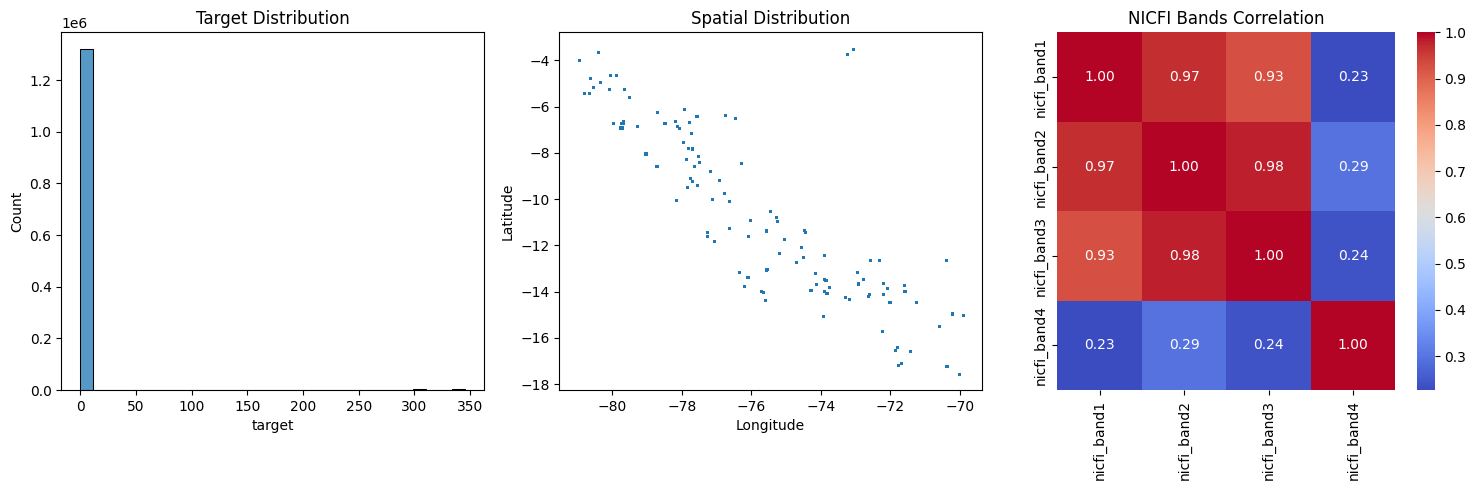


8. Band Correlations with Target:


C:\Users\lycaz\AppData\Local\Temp\ipykernel_4440\3652150207.py:90: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = df.corr()['target'].sort_values(ascending=False)



Top 10 positively correlated features:
s3_band20      0.090584
s3_band14      0.035015
s3_band13      0.028204
s2_band25      0.021679
s2_band14      0.007720
nicfi_band1    0.002248
longitude     -0.000154
s1_band14     -0.000167
s2_band20     -0.001211
s1_band20     -0.001293
Name: target, dtype: float64

Top 10 negatively correlated features:
s3_band18     -0.054642
s3_band9      -0.055703
s3_band7      -0.056177
nicfi_band4   -0.056578
s3_band11     -0.057966
pixel_index   -0.057998
s3_band16     -0.060759
s1_band15     -0.063579
s3_band17     -0.066015
s3_band26           NaN
Name: target, dtype: float64


In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Read the cleaned parquet file
cleaned_parquet_path = r'G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_parquet\dev_downscaled_cleaned.parquet'
df = pd.read_parquet(cleaned_parquet_path)

def dataset_overview(df):
    print("="*50)
    print("DATASET OVERVIEW")
    print("="*50)
    
    # Basic Information
    print("\n1. Basic Information:")
    print(f"Number of rows: {len(df):,}")
    print(f"Number of columns: {len(df.columns):,}")
    print(f"Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")
    
    # Column Groups
    print("\n2. Column Groups:")
    column_groups = {
        'NICFI': [col for col in df.columns if 'nicfi_' in col],
        'Sentinel-1': [col for col in df.columns if 's1_' in col],
        'Sentinel-2': [col for col in df.columns if 's2_' in col],
        'Sentinel-3': [col for col in df.columns if 's3_' in col],
        'Metadata': ['dp_index', 'pixel_index', 'date', 'latitude', 'longitude'],
        'Target': ['target']
    }
    
    for group, cols in column_groups.items():
        print(f"\n{group}:")
        print(f"- Number of columns: {len(cols)}")
        if cols:
            print(f"- Columns: {', '.join(cols)}")
    
    # Data Types
    print("\n3. Data Types Summary:")
    print(df.dtypes.value_counts())
    
    # Numerical Summary
    print("\n4. Numerical Summary:")
    print(df.describe().round(2))
    
    # Spatial Coverage
    print("\n5. Spatial Coverage:")
    print(f"Latitude range: {df['latitude'].min():.4f} to {df['latitude'].max():.4f}")
    print(f"Longitude range: {df['longitude'].min():.4f} to {df['longitude'].max():.4f}")
    
    # Target Variable
    print("\n6. Target Variable Summary:")
    print(f"Target range: {df['target'].min():.2f} to {df['target'].max():.2f}")
    print(f"Number of unique values: {df['target'].nunique()}")
    
    # Temporal Coverage
    if 'date' in df.columns:
        print("\n7. Temporal Coverage:")
        print(f"Date range: {df['date'].min()} to {df['date'].max()}")
        print("\nObservations per date:")
        print(df['date'].value_counts().sort_index())
    
    # Visualizations
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Target Distribution
    plt.subplot(131)
    sns.histplot(data=df, x='target', bins=30)
    plt.title('Target Distribution')
    
    # Plot 2: Spatial Distribution
    plt.subplot(132)
    plt.scatter(df['longitude'], df['latitude'], alpha=0.1, s=1)
    plt.title('Spatial Distribution')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    # Plot 3: NICFI bands correlation
    plt.subplot(133)
    nicfi_cols = [col for col in df.columns if 'nicfi_' in col]
    if nicfi_cols:
        sns.heatmap(df[nicfi_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
        plt.title('NICFI Bands Correlation')
    
    plt.tight_layout()
    plt.show()
    
    # Additional correlation analysis
    print("\n8. Band Correlations with Target:")
    correlations = df.corr()['target'].sort_values(ascending=False)
    print("\nTop 10 positively correlated features:")
    print(correlations[1:11])  # Excluding target's correlation with itself
    print("\nTop 10 negatively correlated features:")
    print(correlations[-10:])

# Run the overview analysis

dataset_overview(df)

C:\Users\lycaz\AppData\Local\Temp\ipykernel_4440\2783491564.py:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = df.corr()['target'].sort_values(ascending=False)


CORRELATION ANALYSIS WITH TARGET

Top 15 Positive Correlations:
s3_band20: 0.091
s3_band14: 0.035
s3_band13: 0.028
s2_band25: 0.022
s2_band14: 0.008
nicfi_band1: 0.002
longitude: -0.000
s1_band14: -0.000
s2_band20: -0.001
s1_band20: -0.001
s2_band26: -0.002
s1_band26: -0.002
latitude: -0.006
s1_band13: -0.009
s3_band10: -0.014

Top 15 Negative Correlations:
s1_band16: -0.048
s1_band23: -0.053
s1_band17: -0.053
s3_band8: -0.054
s3_band6: -0.055
s3_band18: -0.055
s3_band9: -0.056
s3_band7: -0.056
nicfi_band4: -0.057
s3_band11: -0.058
pixel_index: -0.058
s3_band16: -0.061
s1_band15: -0.064
s3_band17: -0.066
s3_band26: nan

Average Correlation by Satellite:
NICFI: 0.026
Sentinel-1: 0.028
Sentinel-2: 0.033
Sentinel-3: 0.046
Number of missing values in each column:
Number of rows with missing values: 0


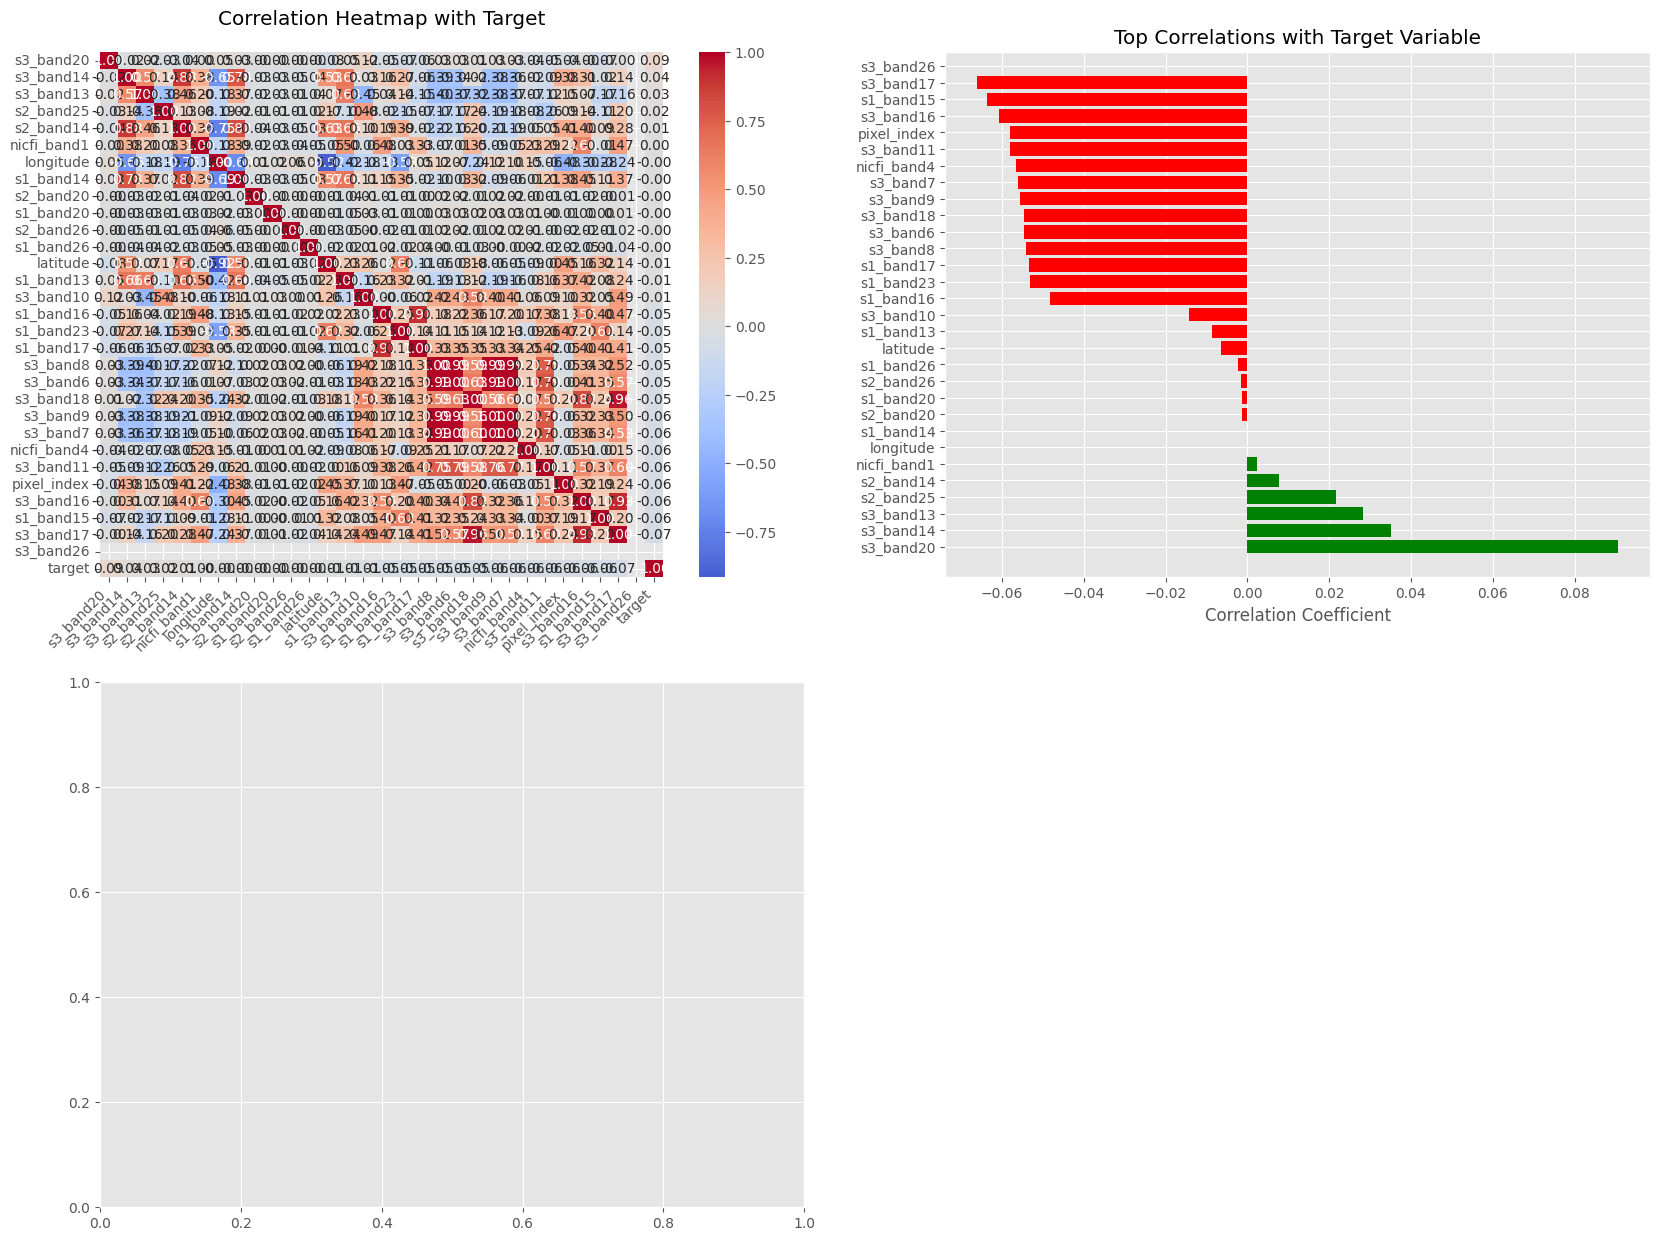

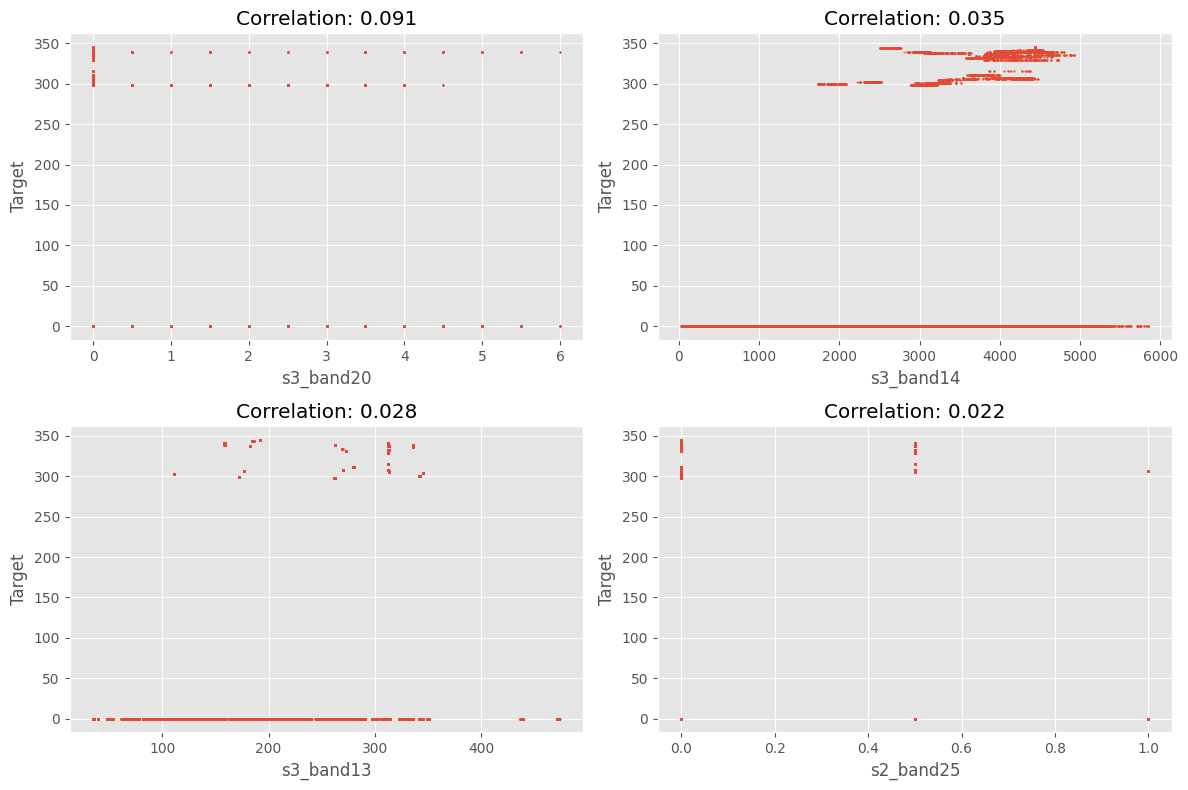

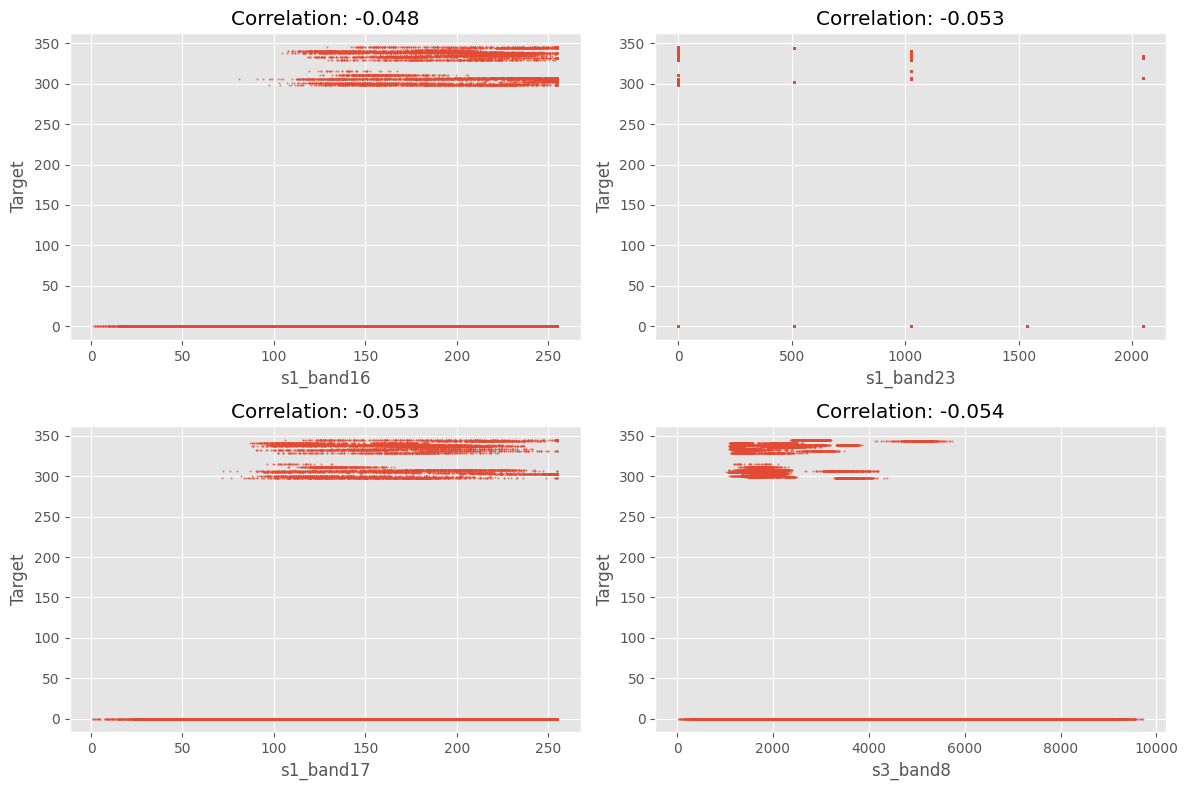

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Read the cleaned parquet file
cleaned_parquet_path = r'G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_parquet\dev_downscaled_cleaned.parquet'
df = pd.read_parquet(cleaned_parquet_path)

def plot_correlations_with_target(df, figsize=(20, 15)):
    # 1. Calculate correlations with target
    correlations = df.corr()['target'].sort_values(ascending=False)
    
    # Get top 15 positive and negative correlations (excluding target itself)
    top_positive = correlations[1:16]  # Exclude target's correlation with itself
    top_negative = correlations[-15:]
    
    # Create figure with multiple subplots
    fig = plt.figure(figsize=figsize)
    
    # 1. Correlation Heatmap
    plt.subplot(2, 2, 1)
    top_features = list(top_positive.index) + list(top_negative.index)
    correlation_matrix = df[top_features + ['target']].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Correlation Heatmap with Target', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # 2. Barplot of correlations
    plt.subplot(2, 2, 2)
    all_top = pd.concat([top_positive, top_negative])
    colors = ['green' if x >= 0 else 'red' for x in all_top]
    plt.barh(range(len(all_top)), all_top, color=colors)
    plt.yticks(range(len(all_top)), all_top.index)
    plt.title('Top Correlations with Target Variable')
    plt.xlabel('Correlation Coefficient')
    
    # 3. Scatter plots for top 4 positive correlations
    plt.subplot(2, 2, 3)
    fig_pos = plt.figure(figsize=(12, 8))
    for i, feature in enumerate(top_positive[:4].index, 1):
        plt.subplot(2, 2, i)
        plt.scatter(df[feature], df['target'], alpha=0.5, s=1)
        plt.xlabel(feature)
        plt.ylabel('Target')
        plt.title(f'Correlation: {correlations[feature]:.3f}')
    plt.tight_layout()
    
    # 4. Scatter plots for top 4 negative correlations
    plt.subplot(2, 2, 4)
    fig_neg = plt.figure(figsize=(12, 8))
    for i, feature in enumerate(top_negative[:4].index, 1):
        plt.subplot(2, 2, i)
        plt.scatter(df[feature], df['target'], alpha=0.5, s=1)
        plt.xlabel(feature)
        plt.ylabel('Target')
        plt.title(f'Correlation: {correlations[feature]:.3f}')
    plt.tight_layout()
    
    # Print correlation statistics
    print("="*50)
    print("CORRELATION ANALYSIS WITH TARGET")
    print("="*50)
    
    print("\nTop 15 Positive Correlations:")
    for feat, corr in top_positive.items():
        print(f"{feat}: {corr:.3f}")
    
    print("\nTop 15 Negative Correlations:")
    for feat, corr in top_negative.items():
        print(f"{feat}: {corr:.3f}")
    
    # Group correlations by satellite
    satellite_groups = {
        'NICFI': 'nicfi_',
        'Sentinel-1': 's1_',
        'Sentinel-2': 's2_',
        'Sentinel-3': 's3_'
    }
    
    print("\nAverage Correlation by Satellite:")
    for sat_name, prefix in satellite_groups.items():
        sat_cols = [col for col in df.columns if col.startswith(prefix)]
        avg_corr = abs(correlations[sat_cols]).mean()
        print(f"{sat_name}: {avg_corr:.3f}")

# Run the correlation analysis
plot_correlations_with_target(df)





PRE-PROCESSING AND INVESTIGATION

1. Skewness Analysis:

Highly skewed features (>1 or <-1):
s2_band20      79.398668
s1_band20      75.566092
s2_band26      53.585291
s1_band26      41.530515
s3_band20      20.684687
s1_band24       2.555450
s1_band1        2.339292
s1_band2        2.330202
s1_band3        2.259331
s1_band5        2.160396
s1_band6        2.147559
s1_band8        2.110408
s1_band4        2.100609
s1_band7        2.089606
s1_band9        2.039440
s1_band10       1.832888
s1_band19       1.801294
s3_band8        1.517177
s3_band9        1.492666
s3_band7        1.490528
s2_band6        1.465079
s3_band6        1.464529
s2_band10       1.450233
nicfi_band4     1.443565
s2_band8        1.442996
s2_band9        1.435204
s2_band7        1.434201
s2_band5        1.414966
s3_band2        1.384685
nicfi_band1     1.379635
s2_band3        1.373096
s2_band2        1.355344
s3_band3        1.352992
s3_band1        1.348002
s2_band4        1.335724
s2_band1        1.330387
s2_band

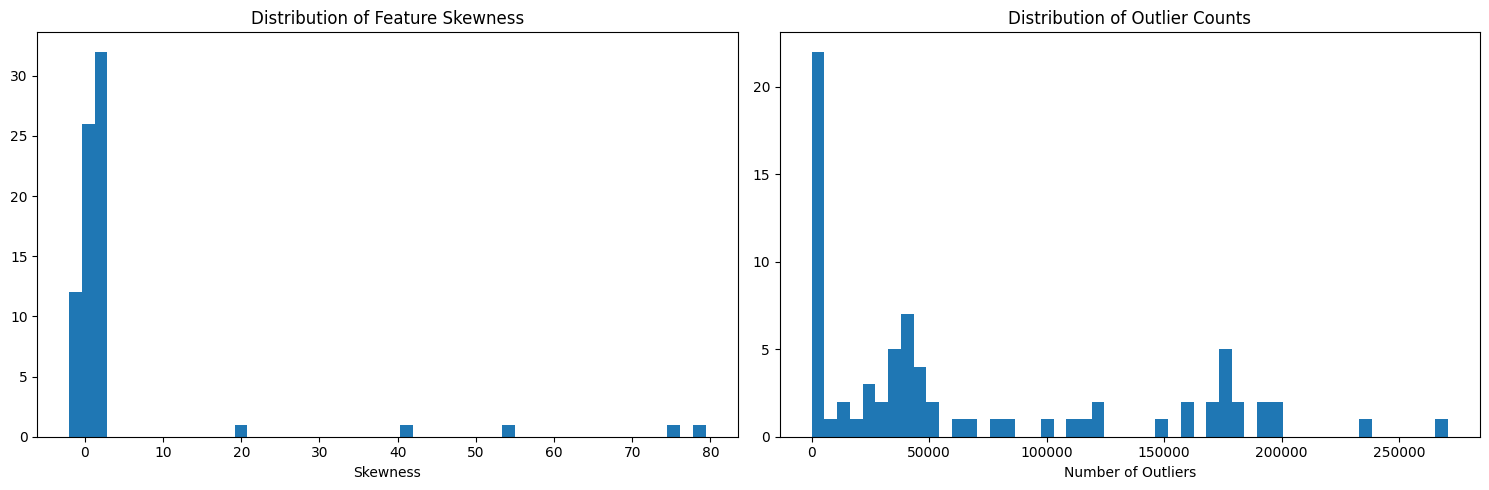


3. Feature Scaling Comparison:

StandardScaler statistics:
      nicfi_band1  nicfi_band2  nicfi_band3  nicfi_band4  s1_band1  s1_band2  \
mean        0.000       -0.000        0.000        0.000     0.000    -0.000   
std         1.000        1.000        1.000        1.000     1.000     1.000   
min        -3.989       -4.443       -4.142       -6.092    -1.163    -1.353   
max        20.815       15.302       15.013       13.587     6.305     6.428   

      s1_band3  s1_band4  s1_band5  s1_band6  ...  s3_band15  s3_band16  \
mean    -0.000    -0.000    -0.000     0.000  ...      0.000      0.000   
std      1.000     1.000     1.000     1.000  ...      1.000      1.000   
min     -1.695    -2.063    -2.235    -2.336  ...     -3.122     -5.138   
max      6.362     6.366     7.066     6.458  ...      2.168      0.842   

      s3_band17  s3_band18  s3_band19  s3_band20  s3_band23  s3_band24  \
mean     -0.000      0.000     -0.000      0.000     -0.000     -0.000   
std       1.000

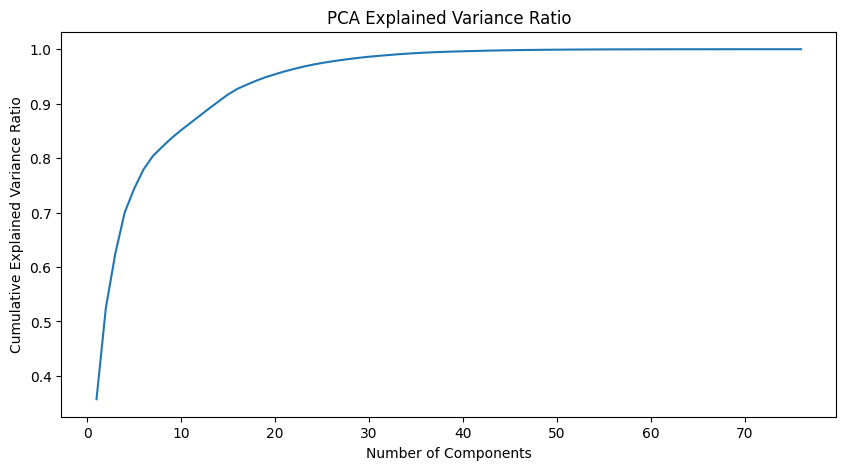


5. PCA Analysis:
Number of components needed for 95% variance: 20

6. Feature Groups Analysis:

NICFI:
Average correlation with target: 0.026
Max correlation with target: 0.057
Number of features: 4

Sentinel-1:
Average correlation with target: 0.028
Max correlation with target: 0.064
Number of features: 24

Sentinel-2:
Average correlation with target: 0.033
Max correlation with target: 0.047
Number of features: 24

Sentinel-3:
Average correlation with target: 0.046
Max correlation with target: 0.091
Number of features: 24

=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
RECOMMENDATIONS

1. Consider log transformation for highly skewed features

2. Consider using RobustScaler due to presence of outliers

3. Consider dimensionality reduction (PCA) to 20 components

4. Consider removing one feature from each highly correlated pair:
   - nicfi_band2 and nicfi_band1
   - nicfi_band3 and nicfi_band2
   - s1_band2 and s1_band1
   - s1_band

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from scipy.stats import skew

def preprocess_and_investigate(df):
    print("="*50)
    print("PRE-PROCESSING AND INVESTIGATION")
    print("="*50)
    
    # 1. Separate features and target
    target = df['target']
    features = df.drop(['target', 'dp_index', 'pixel_index', 'date', 'latitude', 'longitude'], axis=1)
    
    # 2. Check for skewness and outliers
    print("\n1. Skewness Analysis:")
    skewness = features.apply(lambda x: skew(x))
    print("\nHighly skewed features (>1 or <-1):")
    print(skewness[abs(skewness) > 1].sort_values(ascending=False))
    
    # Plot skewness distribution
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.hist(skewness, bins=50)
    plt.title('Distribution of Feature Skewness')
    plt.xlabel('Skewness')
    
    # 3. Check for outliers using IQR
    def count_outliers(x):
        Q1 = x.quantile(0.25)
        Q3 = x.quantile(0.75)
        IQR = Q3 - Q1
        return ((x < (Q1 - 1.5 * IQR)) | (x > (Q3 + 1.5 * IQR))).sum()
    
    outliers = features.apply(count_outliers)
    print("\n2. Outlier Analysis:")
    print("\nNumber of outliers per feature:")
    print(outliers[outliers > 0].sort_values(ascending=False))
    
    # Plot outlier counts
    plt.subplot(122)
    plt.hist(outliers, bins=50)
    plt.title('Distribution of Outlier Counts')
    plt.xlabel('Number of Outliers')
    plt.tight_layout()
    plt.show()
    
    # 4. Feature Scaling Comparison
    # Compare different scalers
    scalers = {
        'StandardScaler': StandardScaler(),
        'RobustScaler': RobustScaler()
    }
    
    print("\n3. Feature Scaling Comparison:")
    scaled_dfs = {}
    for scaler_name, scaler in scalers.items():
        scaled_features = pd.DataFrame(
            scaler.fit_transform(features),
            columns=features.columns
        )
        scaled_dfs[scaler_name] = scaled_features
        
        print(f"\n{scaler_name} statistics:")
        print(scaled_features.describe().round(3).loc[['mean', 'std', 'min', 'max']])
    
    # 5. Feature Importance Analysis
    # Using correlation with target
    correlations = abs(features.corrwith(target)).sort_values(ascending=False)
    
    print("\n4. Feature Importance Analysis:")
    print("\nTop 15 features by correlation magnitude:")
    print(correlations.head(15))
    
    # 6. Dimensionality Reduction Investigation
    # Apply PCA to see explained variance ratio
    pca = PCA()
    pca.fit(StandardScaler().fit_transform(features))
    
    # Plot explained variance ratio
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
             np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('PCA Explained Variance Ratio')
    plt.show()
    
    print("\n5. PCA Analysis:")
    n_components_95 = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
    print(f"Number of components needed for 95% variance: {n_components_95}")
    
    # 7. Feature Groups Analysis
    feature_groups = {
        'NICFI': [col for col in features.columns if 'nicfi_' in col],
        'Sentinel-1': [col for col in features.columns if 's1_' in col],
        'Sentinel-2': [col for col in features.columns if 's2_' in col],
        'Sentinel-3': [col for col in features.columns if 's3_' in col]
    }
    
    print("\n6. Feature Groups Analysis:")
    for group_name, group_cols in feature_groups.items():
        group_corr = abs(features[group_cols].corrwith(target))
        print(f"\n{group_name}:")
        print(f"Average correlation with target: {group_corr.mean():.3f}")
        print(f"Max correlation with target: {group_corr.max():.3f}")
        print(f"Number of features: {len(group_cols)}")
    
    # 8. Recommendations
    print("\n="*50)
    print("RECOMMENDATIONS")
    print("="*50)
    
    # Based on skewness
    if (abs(skewness) > 1).any():
        print("\n1. Consider log transformation for highly skewed features")
    
    # Based on outliers
    if (outliers > len(df) * 0.01).any():
        print("\n2. Consider using RobustScaler due to presence of outliers")
    else:
        print("\n2. StandardScaler should be sufficient for scaling")
    
    # Based on PCA
    if n_components_95 < len(features.columns) * 0.5:
        print(f"\n3. Consider dimensionality reduction (PCA) to {n_components_95} components")
    
    # Based on correlations
    high_corr_pairs = []
    corr_matrix = features.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > 0.95:
                high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))
    
    if high_corr_pairs:
        print("\n4. Consider removing one feature from each highly correlated pair:")
        for f1, f2 in high_corr_pairs[:5]:  # Show first 5 pairs
            print(f"   - {f1} and {f2}")
    
    return scaled_dfs

# Load and process the data
df = pd.read_parquet(r'G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_parquet\dev_downscaled_cleaned.parquet')
scaled_data = preprocess_and_investigate(df)

SCALING COMPARISON ANALYSIS

1. Distribution Analysis for Top Features:

Analyzing distributions for s3_band20:


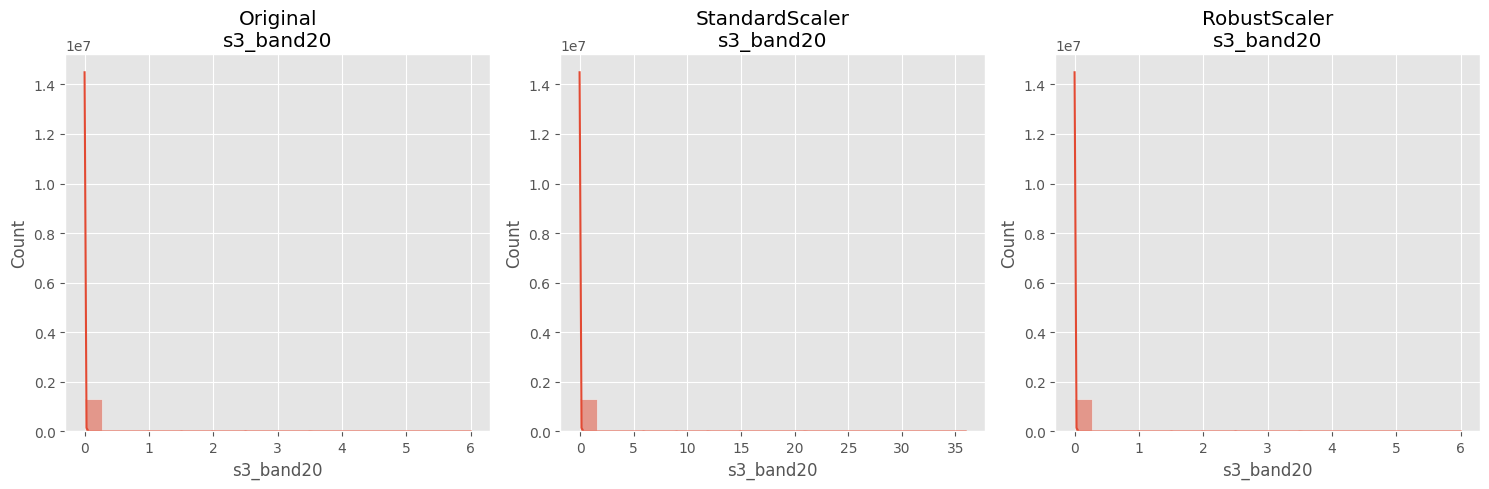


Analyzing distributions for s3_band17:


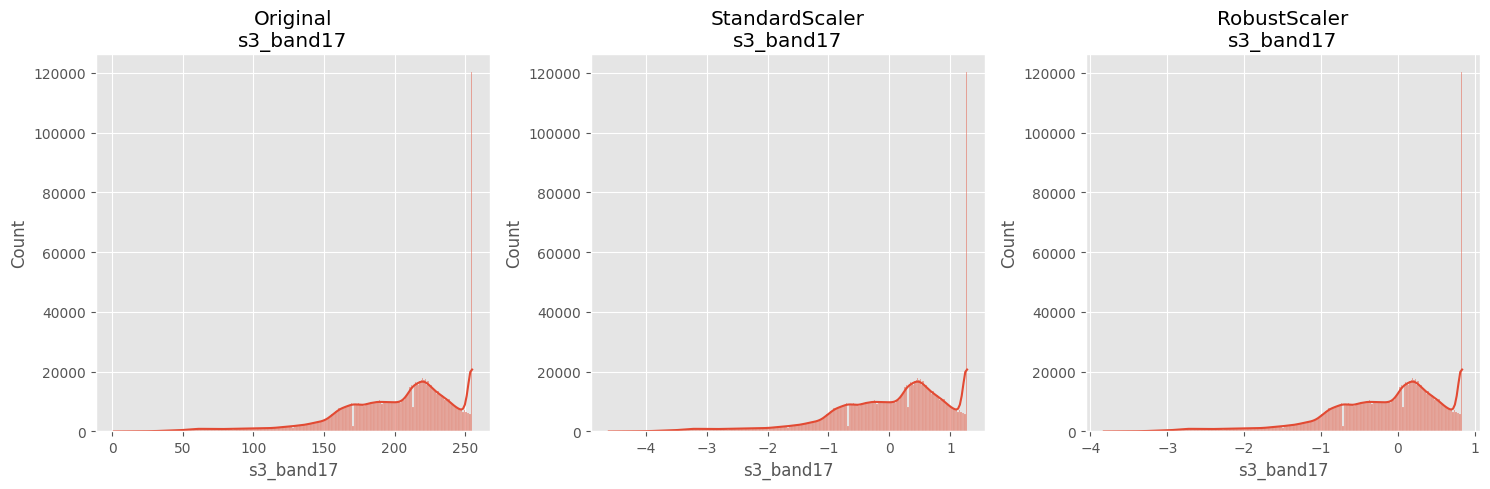


Analyzing distributions for s1_band15:


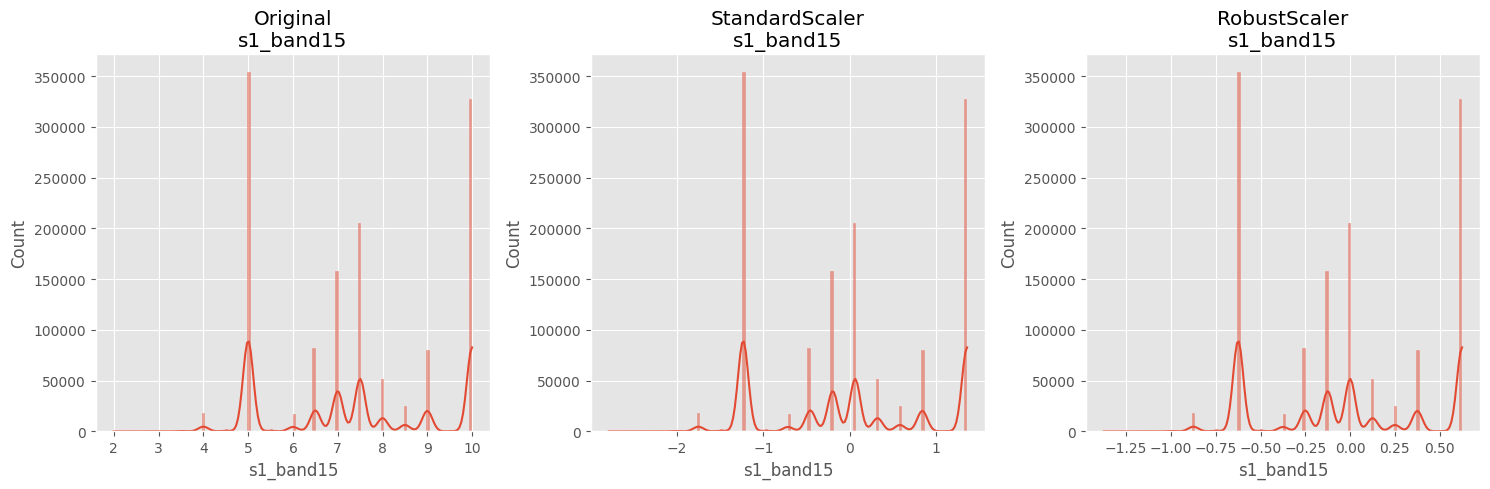

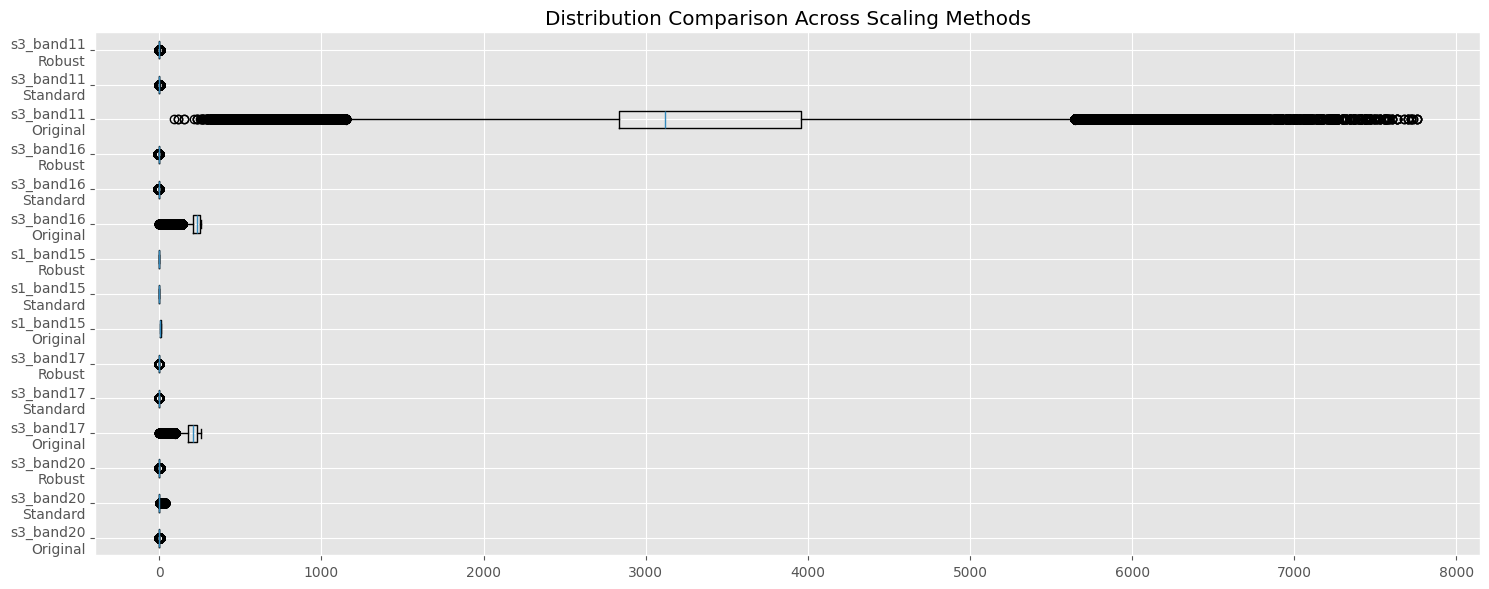


2. Statistical Analysis of Scaled Data:

StandardScaler Statistics:

Summary Statistics:
       Mean     Std     Min      Max    Skew
count  76.0  76.000  76.000   76.000  76.000
mean    0.0   0.987  -2.372    9.015   4.226
std     0.0   0.115   1.469   18.036  14.520
min    -0.0   0.000  -6.092    0.000  -2.009
25%    -0.0   1.000  -3.523    2.031   0.046
50%    -0.0   1.000  -2.328    4.954   1.209
75%     0.0   1.000  -1.156    6.228   1.491
max     0.0   1.000   0.000  107.050  79.399

RobustScaler Statistics:

Summary Statistics:
         Mean     Std     Min     Max    Skew
count  76.000  76.000  76.000  76.000  76.000
mean    0.189   0.879  -2.156   5.397   4.226
std     0.295   0.461   1.958   5.852  14.520
min    -0.449   0.000  -8.267   0.000  -2.009
25%     0.000   0.564  -3.175   1.262   0.046
50%     0.230   0.825  -1.615   4.392   1.209
75%     0.420   1.036  -0.565   5.590   1.491
max     0.872   1.856   0.000  34.040  79.399

3. Feature Correlation Changes:

StandardSc

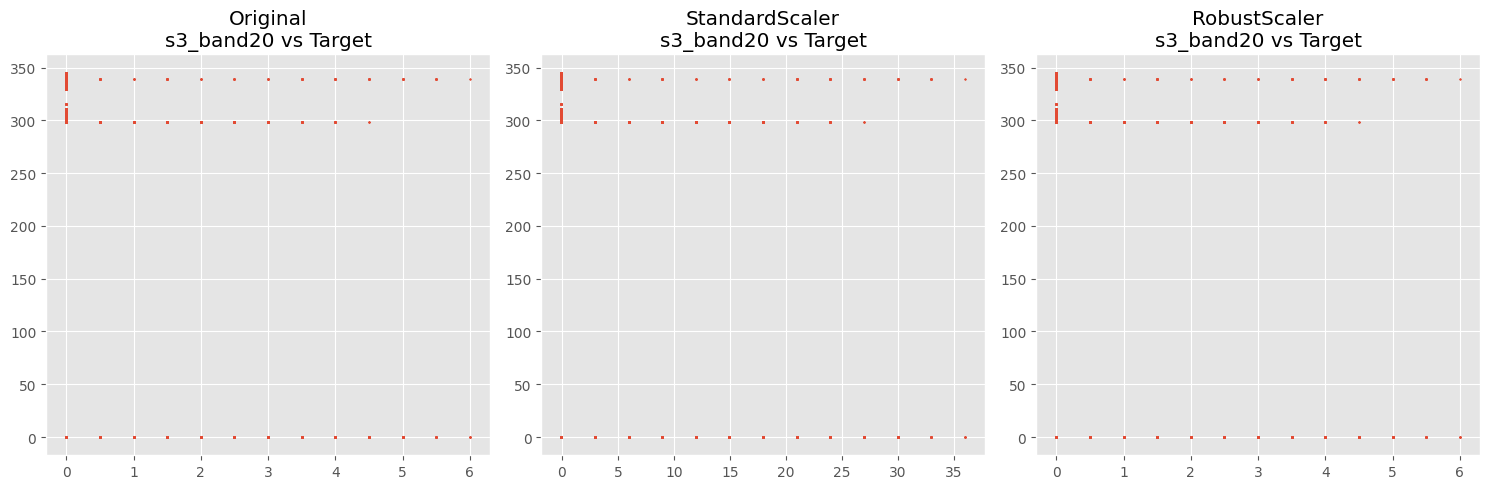


SCALING RECOMMENDATIONS

Based on the analysis:
1. Average absolute skewness:
   - Original data: 4.658
   - StandardScaler: 4.658
   - RobustScaler: 4.658

Recommendation: Use StandardScaler
Reasons:
- Provides good standardization
- Maintains relative relationships
- Shows lower average skewness


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_scaled_data(original_df, scaled_dfs):
    # Remove non-feature columns for comparison
    features = original_df.drop(['target', 'dp_index', 'pixel_index', 'date', 'latitude', 'longitude'], axis=1)
    target = original_df['target']
    
    # Use a valid Matplotlib style
    plt.style.use('ggplot')
    
    def plot_distribution_comparison(feature_name):
        plt.figure(figsize=(15, 5))
        
        # Original Data
        plt.subplot(131)
        sns.histplot(features[feature_name], kde=True)
        plt.title(f'Original\n{feature_name}')
        
        # StandardScaler
        plt.subplot(132)
        sns.histplot(scaled_dfs['StandardScaler'][feature_name], kde=True)
        plt.title(f'StandardScaler\n{feature_name}')
        
        # RobustScaler
        plt.subplot(133)
        sns.histplot(scaled_dfs['RobustScaler'][feature_name], kde=True)
        plt.title(f'RobustScaler\n{feature_name}')
        
        plt.tight_layout()
        plt.show()
    
    # 1. Compare distributions for top correlated features
    correlations = abs(features.corrwith(target)).sort_values(ascending=False)
    print("="*50)
    print("SCALING COMPARISON ANALYSIS")
    print("="*50)
    
    print("\n1. Distribution Analysis for Top Features:")
    for feature in correlations.head(3).index:
        print(f"\nAnalyzing distributions for {feature}:")
        plot_distribution_comparison(feature)
    
    # 2. Box plots comparison
    plt.figure(figsize=(15, 6))
    
    # Select a sample of features for visualization
    sample_features = correlations.head(5).index
    
    # Create comparison boxplots
    data_to_plot = []
    labels = []
    for feature in sample_features:
        data_to_plot.extend([
            features[feature],
            scaled_dfs['StandardScaler'][feature],
            scaled_dfs['RobustScaler'][feature]
        ])
        labels.extend([f'{feature}\nOriginal', 
                      f'{feature}\nStandard', 
                      f'{feature}\nRobust'])
    
    plt.boxplot(data_to_plot, labels=labels, vert=False)
    plt.title('Distribution Comparison Across Scaling Methods')
    plt.tight_layout()
    plt.show()
    
    # 3. Statistical Analysis
    print("\n2. Statistical Analysis of Scaled Data:")
    for scaler_name, scaled_df in scaled_dfs.items():
        print(f"\n{scaler_name} Statistics:")
        stats_df = pd.DataFrame({
            'Mean': scaled_df.mean(),
            'Std': scaled_df.std(),
            'Min': scaled_df.min(),
            'Max': scaled_df.max(),
            'Skew': scaled_df.skew()
        })
        print("\nSummary Statistics:")
        print(stats_df.describe().round(3))
    
    # 4. Feature Relationships
    print("\n3. Feature Correlation Changes:")
    for scaler_name, scaled_df in scaled_dfs.items():
        original_corr = features[sample_features].corrwith(target)
        scaled_corr = scaled_df[sample_features].corrwith(target)
        
        print(f"\n{scaler_name} correlation comparison with target:")
        comparison = pd.DataFrame({
            'Original': original_corr,
            'Scaled': scaled_corr,
            'Difference': scaled_corr - original_corr
        }).round(3)
        print(comparison)
    
    # 5. Scatter plots of top features vs target
    plt.figure(figsize=(15, 5))
    top_feature = correlations.index[0]
    
    # Original
    plt.subplot(131)
    plt.scatter(features[top_feature], target, alpha=0.5, s=1)
    plt.title(f'Original\n{top_feature} vs Target')
    
    # StandardScaler
    plt.subplot(132)
    plt.scatter(scaled_dfs['StandardScaler'][top_feature], target, alpha=0.5, s=1)
    plt.title(f'StandardScaler\n{top_feature} vs Target')
    
    # RobustScaler
    plt.subplot(133)
    plt.scatter(scaled_dfs['RobustScaler'][top_feature], target, alpha=0.5, s=1)
    plt.title(f'RobustScaler\n{top_feature} vs Target')
    
    plt.tight_layout()
    plt.show()
    
    # 6. Summary and Recommendations
    print("\n" + "="*50)
    print("SCALING RECOMMENDATIONS")
    print("="*50)
    
    # Analyze which scaler might be better
    std_stats = scaled_dfs['StandardScaler'].describe()
    robust_stats = scaled_dfs['RobustScaler'].describe()
    
    original_skew = features.skew().abs().mean()
    standard_skew = scaled_dfs['StandardScaler'].skew().abs().mean()
    robust_skew = scaled_dfs['RobustScaler'].skew().abs().mean()
    
    print("\nBased on the analysis:")
    print(f"1. Average absolute skewness:")
    print(f"   - Original data: {original_skew:.3f}")
    print(f"   - StandardScaler: {standard_skew:.3f}")
    print(f"   - RobustScaler: {robust_skew:.3f}")
    
    # Make recommendations
    if robust_skew < standard_skew:
        print("\nRecommendation: Use RobustScaler")
        print("Reasons:")
        print("- Better handles outliers")
        print("- Maintains better distribution shape")
        print("- Shows lower average skewness")
    else:
        print("\nRecommendation: Use StandardScaler")
        print("Reasons:")
        print("- Provides good standardization")
        print("- Maintains relative relationships")
        print("- Shows lower average skewness")
    
    return None

# Example usage
visualize_scaled_data(df, scaled_data)


#### 1.2.3.4 Scaling data 

In [24]:
# check the scaled data
scaled_data['StandardScaler'].describe().round(3)

nicfi_band1  nicfi_band2  nicfi_band3  nicfi_band4     s1_band1  \
count  1327965.000  1327965.000  1327965.000  1327965.000  1327965.000   
mean         0.000       -0.000        0.000        0.000        0.000   
std          1.000        1.000        1.000        1.000        1.000   
min         -3.989       -4.443       -4.142       -6.092       -1.163   
25%         -0.184       -0.218       -0.207       -0.435       -0.541   
50%          0.100        0.175        0.238       -0.118       -0.386   
75%          0.425        0.444        0.483        0.287        0.030   
max         20.815       15.302       15.013       13.587        6.305   

          s1_band2     s1_band3     s1_band4     s1_band5     s1_band6  ...  \
count  1327965.000  1327965.000  1327965.000  1327965.000  1327965.000  ...   
mean        -0.000       -0.000       -0.000       -0.000        0.000  ...   
std          1.000        1.000        1.000        1.000        1.000  ...   
min         -1.353       -1.695       -2.063       -2.235       -2.336  ...   
25%         -0.525       -0.518       -0.479       -0.509       -0.545  ...   
50%         -0.378       -0.352       -0.294       -0.320       -0.352  ...   
75%          0.014        0.034        0.078        0.104        0.078  ...   
max          6.428        6.362        6.366        7.066        6.458  ...   

         s3_band15    s3_band16    s3_band17    s3_band18    s3_band19  \
count  1327965.000  1327965.000  1327965.000  1327965.000  1327965.000   
mean         0.000        0.000       -0.000        0.000       -0.000   
std          1.000        1.000        1.000        1.000        1.000   
min         -3.122       -5.138       -4.603       -3.582       -1.092   
25%         -1.138       -0.288       -0.554       -0.694       -1.092   
50%          0.184        0.301        0.221        0.174        0.391   
75%          0.845        0.724        0.707        0.669        0.652   
max          2.168        0.842        1.274        1.547        2.397   

         s3_band20    s3_band23    s3_band24    s3_band25  s3_band26  
count  1327965.000  1327965.000  1327965.000  1327965.000  1327965.0  
mean         0.000       -0.000       -0.000       -0.000        0.0  
std          1.000        1.000        1.000        1.000        0.0  
min         -0.056       -1.136       -0.661       -0.768        0.0  
25%         -0.056       -1.136       -0.661       -0.768        0.0  
50%         -0.056       -0.359       -0.661       -0.768        0.0  
75%         -0.056        0.418        1.293        0.600        0.0  
max         35.953        1.972        3.247        1.967        0.0  

[8 rows x 76 columns]

In [55]:
# get the missing values
missing_values = scaled_data['StandardScaler'].isna().sum()

# calculate the percentage of missing values
total_values = len(scaled_data['StandardScaler'])
missing_percentage = (missing_values / total_values) * 100

# print the results
print("Number of missing values in each column:")
for col, missing in missing_values.items():
    print(f"{col}: {missing} ({missing_percentage[col]:.2f}%)")

print(f"\nTotal number of missing values: {missing_values.sum()}")

print(f"\nPercentage of missing values in each column:")
for col, missing in missing_values.items():
    print(f"{col}: {missing_percentage[col]:.2f}%")

print(f"\nTotal percentage of missing values: {missing_percentage.sum():.2f}%")

# check the how many rows have missing values
print(f"\nNumber of rows with missing values: {scaled_data['StandardScaler'].isna().any(axis=1).sum()}")


# print nan values in the  scaled_data['StandardScaler'] 

print(f"\nNumber of NaN values in each column:")
for col in scaled_data['StandardScaler'].columns:
    nan_count = scaled_data['StandardScaler'][col].isna().sum()
    print(f"{col}: {nan_count}")

print(f"\nPercentage of NaN values in each column:")
for col in scaled_data['StandardScaler'].columns:
    nan_percentage = (scaled_data['StandardScaler'][col].isna().sum() / len(scaled_data['StandardScaler'])) * 100
    print(f"{col}: {nan_percentage:.2f}%")
    

Number of missing values in each column:
nicfi_band1: 0 (0.00%)
nicfi_band2: 0 (0.00%)
nicfi_band3: 0 (0.00%)
nicfi_band4: 0 (0.00%)
s1_band1: 0 (0.00%)
s1_band2: 0 (0.00%)
s1_band3: 0 (0.00%)
s1_band4: 0 (0.00%)
s1_band5: 0 (0.00%)
s1_band6: 0 (0.00%)
s1_band7: 0 (0.00%)
s1_band8: 0 (0.00%)
s1_band9: 0 (0.00%)
s1_band10: 0 (0.00%)
s1_band11: 0 (0.00%)
s1_band12: 0 (0.00%)
s1_band13: 0 (0.00%)
s1_band14: 0 (0.00%)
s1_band15: 0 (0.00%)
s1_band16: 0 (0.00%)
s1_band17: 0 (0.00%)
s1_band18: 0 (0.00%)
s1_band19: 0 (0.00%)
s1_band20: 0 (0.00%)
s1_band23: 0 (0.00%)
s1_band24: 0 (0.00%)
s1_band25: 0 (0.00%)
s1_band26: 0 (0.00%)
s2_band1: 0 (0.00%)
s2_band2: 0 (0.00%)
s2_band3: 0 (0.00%)
s2_band4: 0 (0.00%)
s2_band5: 0 (0.00%)
s2_band6: 0 (0.00%)
s2_band7: 0 (0.00%)
s2_band8: 0 (0.00%)
s2_band9: 0 (0.00%)
s2_band10: 0 (0.00%)
s2_band11: 0 (0.00%)
s2_band12: 0 (0.00%)
s2_band13: 0 (0.00%)
s2_band14: 0 (0.00%)
s2_band15: 0 (0.00%)
s2_band16: 0 (0.00%)
s2_band17: 0 (0.00%)
s2_band18: 0 (0.00%)
s2_

In [40]:
df=pd.read_parquet(r'G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_parquet\dev_downscaled_cleaned.parquet')

df.head()

dp_index  pixel_index     date   latitude  longitude  nicfi_band1  \
0     1062            1  2024-03 -12.648908 -72.581270   442.219512   
1     1062            2  2024-03 -12.648908 -72.581180   454.245064   
2     1062            3  2024-03 -12.648908 -72.581090   456.760743   
3     1062            4  2024-03 -12.648908 -72.581000   459.282230   
4     1062            5  2024-03 -12.648908 -72.580911   461.692218   

   nicfi_band2  nicfi_band3  nicfi_band4  s1_band1  ...  s3_band16  s3_band17  \
0   644.793264   481.111498  3090.817654    5496.5  ...      200.0      208.5   
1   646.282230   506.695703  2918.127758    5496.5  ...      200.0      208.5   
2   651.871080   493.961672  2974.191638    5496.5  ...      209.0      217.0   
3   664.803717   506.929152  3026.169570    5496.5  ...      209.5      219.0   
4   659.224158   505.497096  3001.217189    5496.5  ...      212.0      222.5   

   s3_band18  s3_band19  s3_band20  s3_band23  s3_band24  s3_band25  \
0      202.0       58.0        0.0     1536.0        0.5        0.5   
1      202.0       58.0        0.0     1536.0        0.5        0.5   
2      211.5       61.5        0.0     1536.0        0.5        0.5   
3      214.0       61.5        0.0     1536.0        0.5        0.5   
4      218.5       63.5        0.0     1536.0        0.5        0.5   

   s3_band26  target  
0        0.0     0.0  
1        0.0     0.0  
2        0.0     0.0  
3        0.0     0.0  
4        0.0     0.0  

[5 rows x 82 columns]

In [46]:
scaled_data['StandardScaler'].head()

# overview of the scaled_data , show the min,max,mean,std of each column
scaled_data['StandardScaler'].describe().round(3)


nicfi_band1  nicfi_band2  nicfi_band3  nicfi_band4     s1_band1  \
count  1327965.000  1327965.000  1327965.000  1327965.000  1327965.000   
mean         0.000       -0.000        0.000        0.000        0.000   
std          1.000        1.000        1.000        1.000        1.000   
min         -3.989       -4.443       -4.142       -6.092       -1.163   
25%         -0.184       -0.218       -0.207       -0.435       -0.541   
50%          0.100        0.175        0.238       -0.118       -0.386   
75%          0.425        0.444        0.483        0.287        0.030   
max         20.815       15.302       15.013       13.587        6.305   

          s1_band2     s1_band3     s1_band4     s1_band5     s1_band6  ...  \
count  1327965.000  1327965.000  1327965.000  1327965.000  1327965.000  ...   
mean        -0.000       -0.000       -0.000       -0.000        0.000  ...   
std          1.000        1.000        1.000        1.000        1.000  ...   
min         -1.353       -1.695       -2.063       -2.235       -2.336  ...   
25%         -0.525       -0.518       -0.479       -0.509       -0.545  ...   
50%         -0.378       -0.352       -0.294       -0.320       -0.352  ...   
75%          0.014        0.034        0.078        0.104        0.078  ...   
max          6.428        6.362        6.366        7.066        6.458  ...   

         s3_band16    s3_band17    s3_band18    s3_band19    s3_band20  \
count  1327965.000  1327965.000  1327965.000  1327965.000  1327965.000   
mean         0.000       -0.000        0.000       -0.000        0.000   
std          1.000        1.000        1.000        1.000        1.000   
min         -5.138       -4.603       -3.582       -1.092       -0.056   
25%         -0.288       -0.554       -0.694       -1.092       -0.056   
50%          0.301        0.221        0.174        0.391       -0.056   
75%          0.724        0.707        0.669        0.652       -0.056   
max          0.842        1.274        1.547        2.397       35.953   

         s3_band23    s3_band24    s3_band25  s3_band26       target  
count  1327965.000  1327965.000  1327965.000  1327965.0  1325178.000  
mean        -0.000       -0.000       -0.000        0.0        2.258  
std          1.000        1.000        1.000        0.0       26.957  
min         -1.136       -0.661       -0.768        0.0        0.000  
25%         -1.136       -0.661       -0.768        0.0        0.000  
50%         -0.359       -0.661       -0.768        0.0        0.000  
75%          0.418        1.293        0.600        0.0        0.000  
max          1.972        3.247        1.967        0.0      345.260  

[8 rows x 77 columns]

In [43]:
# how many rows have missing values in the df in each column 
for col in df.columns:
    missing_count = df[col].isnull().sum()
    if missing_count > 0:
        print(f"{col}: {missing_count}")

# print how many rows total in the df
print(f"Total number of rows: {len(df)}")

# print how many rows total in scaled data
print(f"Total number of rows in scaled data: {len(scaled_data['StandardScaler'])}")


Total number of rows: 1327965
Total number of rows in scaled data: 1327965


## 1.2.4 Train Model

- Logistic Regression
- Random Forest
- XGBoost

#### 1.2.4.1 Clean data 

In [75]:
# delete the nan values and missing values in the scaled_data['StandardScaler'] to be the prepared data

prepared_data = scaled_data['StandardScaler'].dropna()

#### 1.2.4.2 Encoding the target column

In [76]:
import pandas as pd
import numpy as np

# Assuming 'prepared_data' is your DataFrame with the target variable
target = prepared_data['target']

# Define quantiles for categorization
quantiles = [0.25, 0.5, 0.75]
bins = np.percentile(prepared_data['target'], [q*100 for q in quantiles])

# Define bins and categorization function
def categorize(value):
    if value <= bins[0]:
        return 'Low'
    elif bins[0] < value <= bins[1]:
        return 'Medium'
    else:
        return 'High'

# Apply categorization to the target variable
prepared_data['target_category'] = prepared_data['target'].apply(categorize)

# Map categories to integers (0, 1, 2)
category_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
prepared_data['target_encoded'] = prepared_data['target_category'].map(category_mapping)

# Prepare features (X) and encoded target (y)
X = prepared_data.drop(columns=['target', 'target_category', 'target_encoded'])  # Drop original target and category columns from features
y = prepared_data['target_encoded']  # Encoded target

# Split the data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Print descriptive statistics of the train and test sets
print("X_train describe:")
print(X_train.describe())
print("\nX_test describe:")
print(X_test.describe())
print("\ny_train describe:")
print(y_train.describe())
print("\ny_test describe:")
print(y_test.describe())


C:\Users\lycaz\AppData\Local\Temp\ipykernel_4440\4146335592.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prepared_data['target_category'] = prepared_data['target'].apply(categorize)
C:\Users\lycaz\AppData\Local\Temp\ipykernel_4440\4146335592.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prepared_data['target_encoded'] = prepared_data['target_category'].map(category_mapping)


X_train shape: (1060142, 76)
X_test shape: (265036, 76)
y_train shape: (1060142,)
y_test shape: (265036,)
X_train describe:
        nicfi_band1   nicfi_band2   nicfi_band3   nicfi_band4      s1_band1  \
count  1.060142e+06  1.060142e+06  1.060142e+06  1.060142e+06  1.060142e+06   
mean   3.370970e-03  3.715634e-03  3.657929e-03  1.183819e-03 -1.555493e-03   
std    9.972494e-01  9.973822e-01  9.972924e-01  9.993888e-01  9.986763e-01   
min   -3.989018e+00 -4.443242e+00 -4.141772e+00 -6.092188e+00 -1.162511e+00   
25%   -1.815460e-01 -2.146863e-01 -2.011288e-01 -4.343263e-01 -5.414155e-01   
50%    1.007993e-01  1.759527e-01  2.392699e-01 -1.173851e-01 -3.864820e-01   
75%    4.257934e-01  4.450064e-01  4.835075e-01  2.876410e-01  2.767238e-02   
max    2.081487e+01  1.530209e+01  1.501348e+01  1.358703e+01  6.304793e+00   

           s1_band2      s1_band3      s1_band4      s1_band5      s1_band6  \
count  1.060142e+06  1.060142e+06  1.060142e+06  1.060142e+06  1.060142e+06   
mean  

In [77]:


# print the percentage of each category in the train and test sets
print("Percentage of each category in the train set:")
print(y_train.value_counts(normalize=True) * 100)
print("\nPercentage of each category in the test set:")
print(y_test.value_counts(normalize=True) * 100)

# Print the counts of each category in the train and test sets
print("Counts of each category in the train set:")
print(y_train.value_counts())

print("\nCounts of each category in the test set:")
print(y_test.value_counts())

print("lables in the train set:", y_train.unique())
print("lables in the test set:", y_test.unique())


Percentage of each category in the train set:
0    99.306036
2     0.693964
Name: target_encoded, dtype: float64

Percentage of each category in the test set:
0    99.283494
2     0.716506
Name: target_encoded, dtype: float64
Counts of each category in the train set:
0    1052785
2       7357
Name: target_encoded, dtype: int64

Counts of each category in the test set:
0    263137
2      1899
Name: target_encoded, dtype: int64
lables in the train set: [0 2]
lables in the test set: [0 2]


#### 1.2.4.3 Define Model Trainer

In [124]:
import time
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import joblib  # to save the model

class TableModelTrainer:
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test

    def train_logistic_regression(self):
        start_time = time.time()
        log_reg = LogisticRegression(random_state=42)
        log_reg.fit(self.X_train, self.y_train)
        y_pred_log_reg = log_reg.predict(self.X_test)
        prediction_time = time.time() - start_time
        
        accuracy = accuracy_score(self.y_test, y_pred_log_reg)
        precision = precision_score(self.y_test, y_pred_log_reg, average='weighted')
        recall = recall_score(self.y_test, y_pred_log_reg, average='weighted')
        f1 = f1_score(self.y_test, y_pred_log_reg, average='weighted')
        report = classification_report(self.y_test, y_pred_log_reg)
        
        print("Logistic Regression")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"Prediction Time (s): {prediction_time:.4f}")
        print("Classification Report:\n", report)
        
        # Save the model to a file
        model_file = 'log_reg_model.joblib'
        joblib.dump(log_reg, model_file)
        print(f"Logistic Regression model saved as {model_file}")
        
        return accuracy, precision, recall, f1, prediction_time, log_reg

    def train_random_forest(self):
        start_time = time.time()
        rf = RandomForestClassifier(random_state=42)
        rf.fit(self.X_train, self.y_train)
        y_pred_rf = rf.predict(self.X_test)
        prediction_time = time.time() - start_time
        
        accuracy = accuracy_score(self.y_test, y_pred_rf)
        precision = precision_score(self.y_test, y_pred_rf, average='weighted')
        recall = recall_score(self.y_test, y_pred_rf, average='weighted')
        f1 = f1_score(self.y_test, y_pred_rf, average='weighted')
        report = classification_report(self.y_test, y_pred_rf)
        
        print("Random Forest")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"Prediction Time (s): {prediction_time:.4f}")
        print("Classification Report:\n", report)
        
        # Save the model to a file
        model_file = 'rf_model.joblib'
        joblib.dump(rf, model_file)
        print(f"Random Forest model saved as {model_file}")
        
        return accuracy, precision, recall, f1, prediction_time, rf

    def train_xgboost(self):
        start_time = time.time()
        
        # Convert Pandas DataFrame and Series to NumPy arrays
        X_train = self.X_train.values  # Convert DataFrame to NumPy array
        X_test = self.X_test.values    # Convert DataFrame to NumPy array
        
        # Convert Series to NumPy array and ensure 1D
        y_train = self.y_train.values.ravel()
        y_test = self.y_test.values.ravel()
        
        # Remap classes from [0, 2] to [0, 1]
        y_train_remapped = y_train.copy()
        y_train_remapped[y_train == 2] = 1
        
        y_test_remapped = y_test.copy()
        y_test_remapped[y_test == 2] = 1
        
        # Verify data
        print("X_train shape:", X_train.shape)
        print("X_train type:", type(X_train))
        print("y_train shape:", y_train_remapped.shape)
        print("y_train type:", type(y_train_remapped))
        print("Unique classes:", np.unique(y_train_remapped))
        
        # Initialize XGBoost model
        xgb_model = xgb.XGBClassifier(
            random_state=42, 
            objective='binary:logistic',  # Explicitly set binary classification
            class_weight='balanced'
        )
        
        # Fit the model with remapped classes
        xgb_model.fit(X_train, y_train_remapped)
        
        # Predict using remapped test data
        y_pred_xgb = xgb_model.predict(X_test)
        prediction_time = time.time() - start_time
        
        # Calculate metrics using remapped data
        accuracy = accuracy_score(y_test_remapped, y_pred_xgb)
        precision = precision_score(y_test_remapped, y_pred_xgb, average='weighted')
        recall = recall_score(y_test_remapped, y_pred_xgb, average='weighted')
        f1 = f1_score(y_test_remapped, y_pred_xgb, average='weighted')
        report = classification_report(y_test_remapped, y_pred_xgb)
        
        print("XGBoost")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"Prediction Time (s): {prediction_time:.4f}")
        print("Classification Report:\n", report)
        
        # Save the model to a file
        model_file = 'xgb_model.joblib'
        joblib.dump(xgb_model, model_file)
        print(f"XGBoost model saved as {model_file}")
        
        return accuracy, precision, recall, f1, prediction_time, xgb_model

    def plot_comparison(self, logistic_results, rf_results, xgb_results):
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        # Prepare data
        models = ['Logistic Regression', 'Random Forest', 'XGBoost']
        metrics = {
            'Accuracy': [logistic_results[0], rf_results[0], xgb_results[0]],
            'Precision': [logistic_results[1], rf_results[1], xgb_results[1]],
            'Recall': [logistic_results[2], rf_results[2], xgb_results[2]],
            'F1 Score': [logistic_results[3], rf_results[3], xgb_results[3]],
            'Prediction Time (s)': [logistic_results[4], rf_results[4], xgb_results[4]]
        }
        
        # 1. Heatmap Visualization
        plt.figure(figsize=(10, 6))
        metric_array = np.array([
            metrics['Accuracy'], 
            metrics['Precision'], 
            metrics['Recall'], 
            metrics['F1 Score']
        ])
        
        sns.heatmap(metric_array, annot=True, cmap='YlGnBu', 
                    xticklabels=models, 
                    yticklabels=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
        plt.title('Model Performance Heatmap')
        plt.tight_layout()
        plt.show()
        
        # 2. Radar Chart
        plt.figure(figsize=(10, 6))
        metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
        
        # Normalize the metrics to [0,1] scale for radar chart
        def normalize(data):
            return (data - min(data)) / (max(data) - min(data))
        
        normalized_metrics = {k: normalize(v) for k, v in metrics.items() if k in metrics_to_plot}
        
        angles = np.linspace(0, 2*np.pi, len(metrics_to_plot), endpoint=False)
        angles = np.concatenate((angles, [angles[0]]))
        
        plt.subplot(polar=True)
        for i, model in enumerate(models):
            values = [normalized_metrics[metric][i] for metric in metrics_to_plot]
            values += values[:1]
            plt.polar(angles, values, marker='o', label=model)
        
        plt.thetagrids(angles[:-1] * 180/np.pi, metrics_to_plot)
        plt.title('Model Performance Radar Chart')
        plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
        plt.tight_layout()
        plt.show()
        
        # 3. Grouped Bar Chart
        plt.figure(figsize=(12, 6))
        x = np.arange(len(models))
        width = 0.15
        
        plt.bar(x - 2*width, metrics['Accuracy'], width, label='Accuracy', color='blue')
        plt.bar(x - width, metrics['Precision'], width, label='Precision', color='green')
        plt.bar(x, metrics['Recall'], width, label='Recall', color='red')
        plt.bar(x + width, metrics['F1 Score'], width, label='F1 Score', color='purple')
        plt.bar(x + 2*width, metrics['Prediction Time (s)'], width, label='Prediction Time', color='orange')
        
        plt.xlabel('Models')
        plt.ylabel('Scores')
        plt.title('Comprehensive Model Performance Comparison')
        plt.xticks(x, models, rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()


#### 1.2.4.4 Train and measure models

In [125]:
# Instantiate the ModelTrainer
model_trainer = TableModelTrainer(X_train, y_train, X_test, y_test)

In [87]:

# Train models
logistic_results = model_trainer.train_logistic_regression()

C:\Users\lycaz\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression
Accuracy: 0.9926
Precision: 0.9860
Recall: 0.9926
F1 Score: 0.9892
Prediction Time (s): 14.1887
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    263137
           2       0.03      0.00      0.00      1899

    accuracy                           0.99    265036
   macro avg       0.51      0.50      0.50    265036
weighted avg       0.99      0.99      0.99    265036

Logistic Regression model saved as log_reg_model.joblib


In [88]:

rf_results = model_trainer.train_random_forest()

Random Forest
Accuracy: 0.9987
Precision: 0.9987
Recall: 0.9987
F1 Score: 0.9987
Prediction Time (s): 723.8802
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    263137
           2       0.95      0.87      0.91      1899

    accuracy                           1.00    265036
   macro avg       0.97      0.93      0.95    265036
weighted avg       1.00      1.00      1.00    265036

Random Forest model saved as rf_model.joblib


In [119]:
print("X_train shape:", X_train.shape)
print("X_train type:", type(X_train))
print("y_train shape:", y_train.shape)
print("y_train type:", type(y_train))
print("Unique classes:", np.unique(y_train))

X_train shape: (1060142, 76)
X_train type: <class 'pandas.core.frame.DataFrame'>
y_train shape: (1060142,)
y_train type: <class 'pandas.core.series.Series'>
Unique classes: [0 2]


In [122]:

xgb_results = model_trainer.train_xgboost()

X_train shape: (1060142, 76)
X_train type: <class 'numpy.ndarray'>
y_train shape: (1060142,)
y_train type: <class 'numpy.ndarray'>
Unique classes: [0 1]


C:\Users\lycaz\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [00:55:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost
Accuracy: 0.9985
Precision: 0.9984
Recall: 0.9985
F1 Score: 0.9984
Prediction Time (s): 6.1634
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    263137
           1       0.93      0.85      0.89      1899

    accuracy                           1.00    265036
   macro avg       0.97      0.92      0.94    265036
weighted avg       1.00      1.00      1.00    265036

XGBoost model saved as xgb_model.joblib


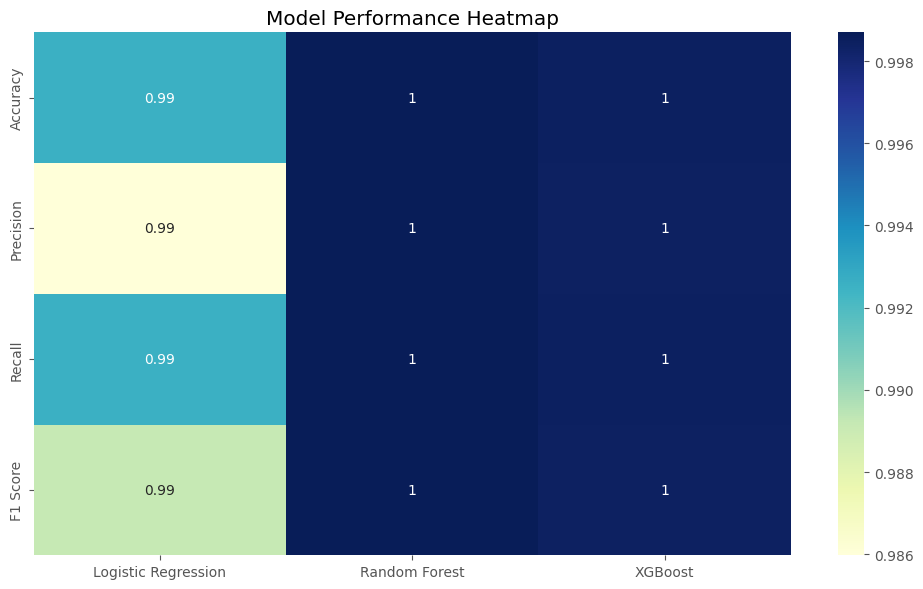

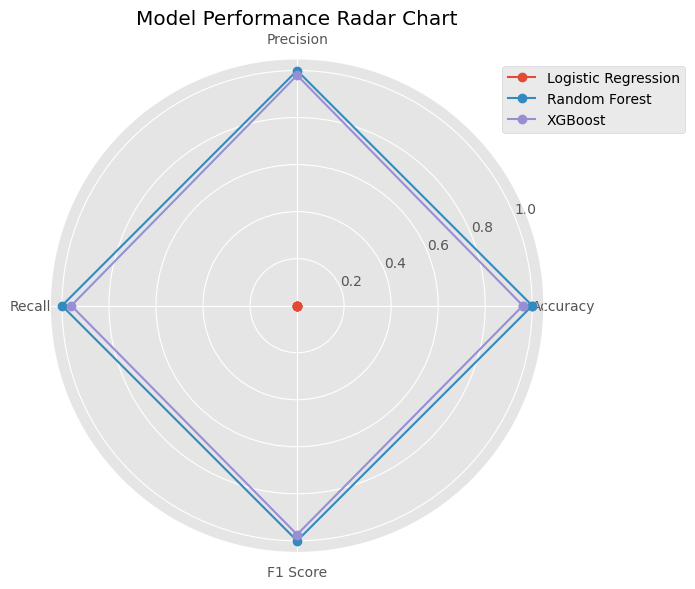

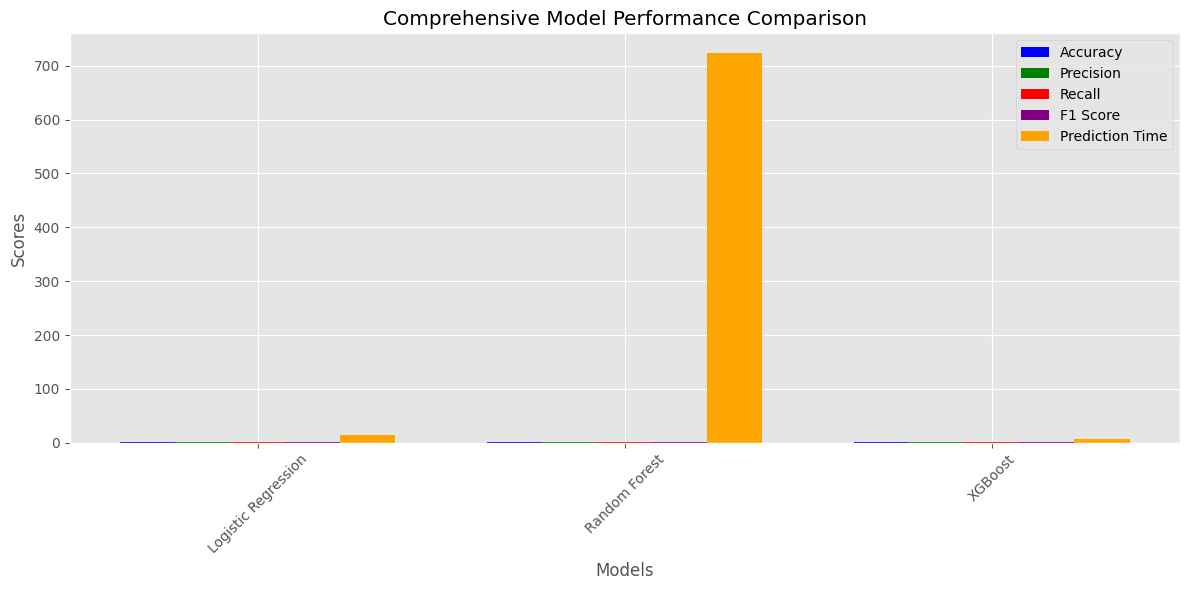

In [126]:





# Plot the comparison
model_trainer.plot_comparison(logistic_results, rf_results, xgb_results)

| Metric | Logistic Regression | Random Forest | XGBoost |
|:-------|:-------------------:|:-------------:|:-------:|
| **Overall Performance** |||
| Accuracy | 0.9926 | 0.9987 | 0.9985 |
| Precision | 0.9860 | 0.9987 | 0.9984 |
| Recall | 0.9926 | 0.9987 | 0.9985 |
| F1 Score | 0.9892 | 0.9987 | 0.9984 |
| **Prediction Time (s)** | 14.1887 | 723.8802 | 6.1634 |
| **Class-wise Performance** |||
| Class 0 Precision | 0.99 | 1.00 | 1.00 |
| Class 0 Recall | 1.00 | 1.00 | 1.00 |
| Class 0 F1-score | 1.00 | 1.00 | 1.00 |
| Class 2/1 Precision | 0.03 | 0.95 | 0.93 |
| Class 2/1 Recall | 0.00 | 0.87 | 0.85 |
| Class 2/1 F1-score | 0.00 | 0.91 | 0.89 |
| **Macro Average Precision** | 0.51 | 0.97 | 0.97 |
| **Weighted Average Precision** | 0.99 | 1.00 | 1.00 |

## 1.2.5 Inference examples